# Initial Data Analysis

In [22]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Visualize Raw Data

E:\Anaconda\envs\tensorflow\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


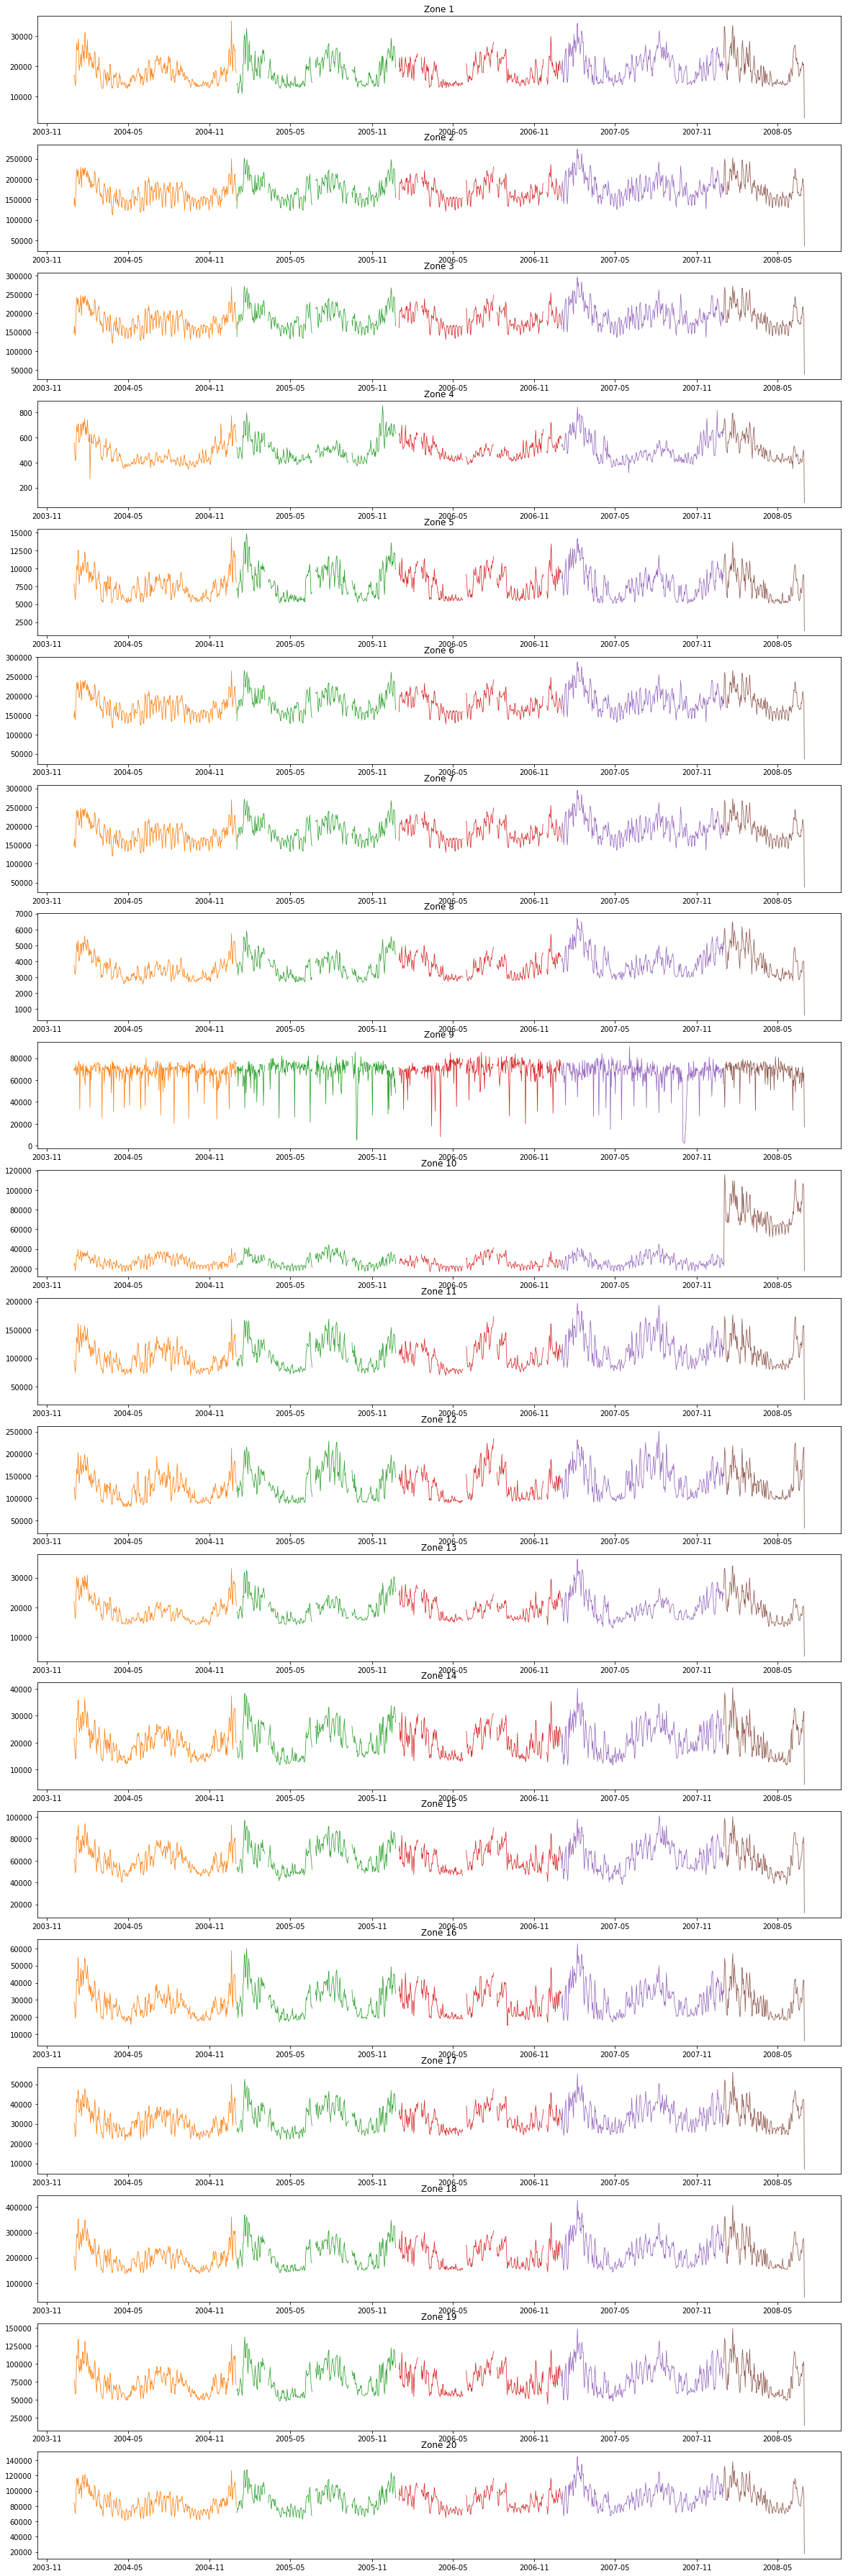

In [4]:
df = pd.read_csv('../data/Load_history.csv')
weather = pd.read_csv('../data/temperature_history.csv')
hourColumn = [f'h{i+1}' for i in range(24)]
df["date"] = pd.to_datetime(df[['year', 'month', 'day']])
def getValue(x):
    v =  x[hourColumn].sum() / 24
    if v == 0:
        return np.nan
    return v
df["average"] =  df.apply(lambda x: getValue(x) , axis=1)
zones = len(df['zone_id'].unique())
def getGlobalTrend():
    plt.close()
    fig, ax = plt.subplots(20, figsize=(20,65))
    for i in range(20):
        data = df[df['zone_id']==i+1]#.sort_values(by="date")
        ax[i].set_title(f'Zone {i+1}')
        for j in range(2003, 2009):
            d = data[data['year'] == j]
            ax[i].plot(d['date'], d['average'], label=j, linewidth=0.75)
    #plt.savefig('YealyChange.png')
    plt.show()
getGlobalTrend()

In [8]:
df = pd.read_csv('aggr.csv') # each zone
df['time'] = pd.to_datetime(df['time'])
total = df.groupby(['time','t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8',
       't9', 't10', 't11']).sum().reset_index() # zone 21
total['time'] = pd.to_datetime(total['time'])

In [19]:
null_data = df[df.isnull().any(axis=1)]
null_data['time'].unique()

array(['2005-03-06T00:00:00.000000000', '2005-03-06T01:00:00.000000000',
       '2005-03-06T02:00:00.000000000', ...,
       '2008-07-07T21:00:00.000000000', '2008-07-07T22:00:00.000000000',
       '2008-07-07T23:00:00.000000000'], dtype='datetime64[ns]')

### Auto Correlation Plot
- Zone 9, Zone 10 is weird.
- Seasonality is critical.

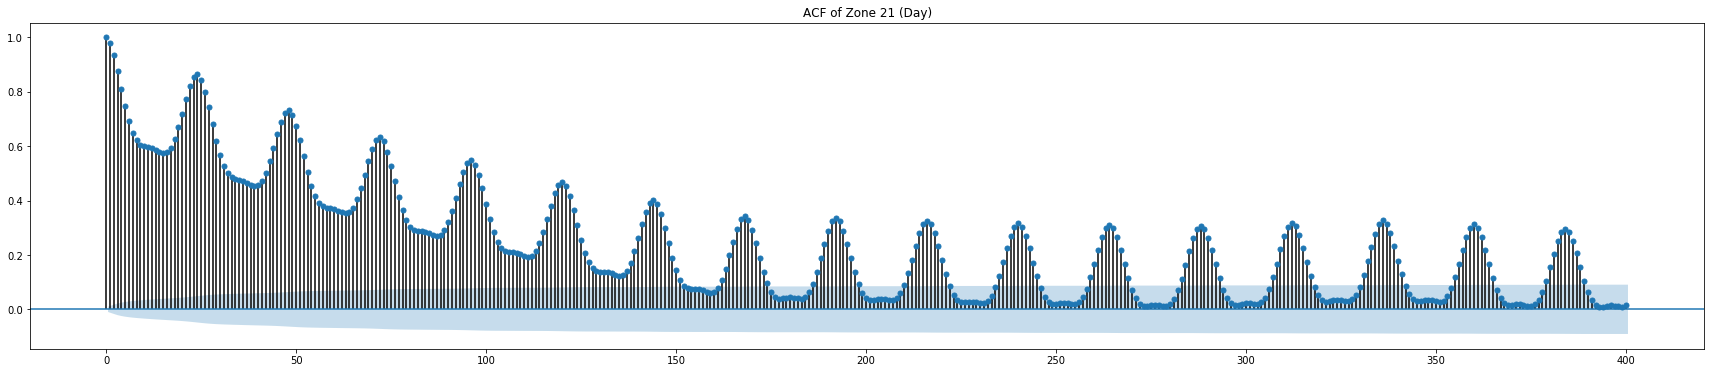

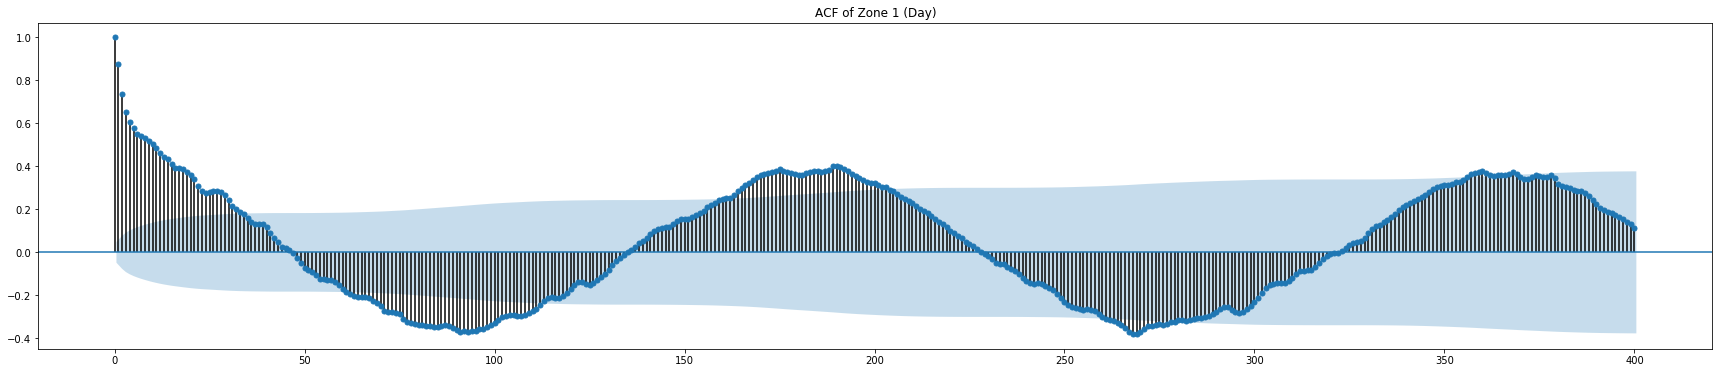

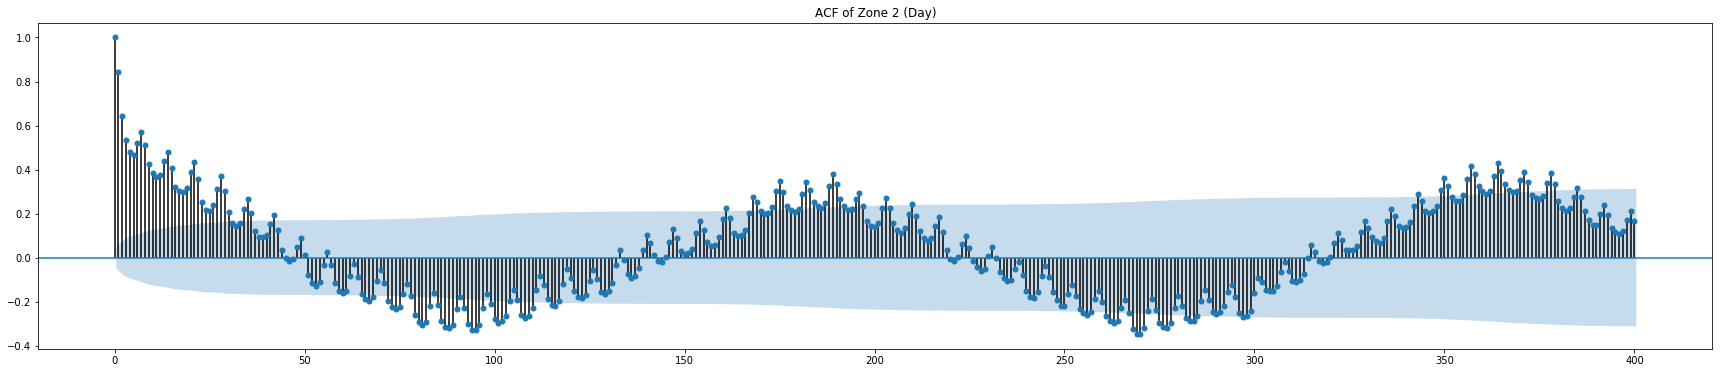

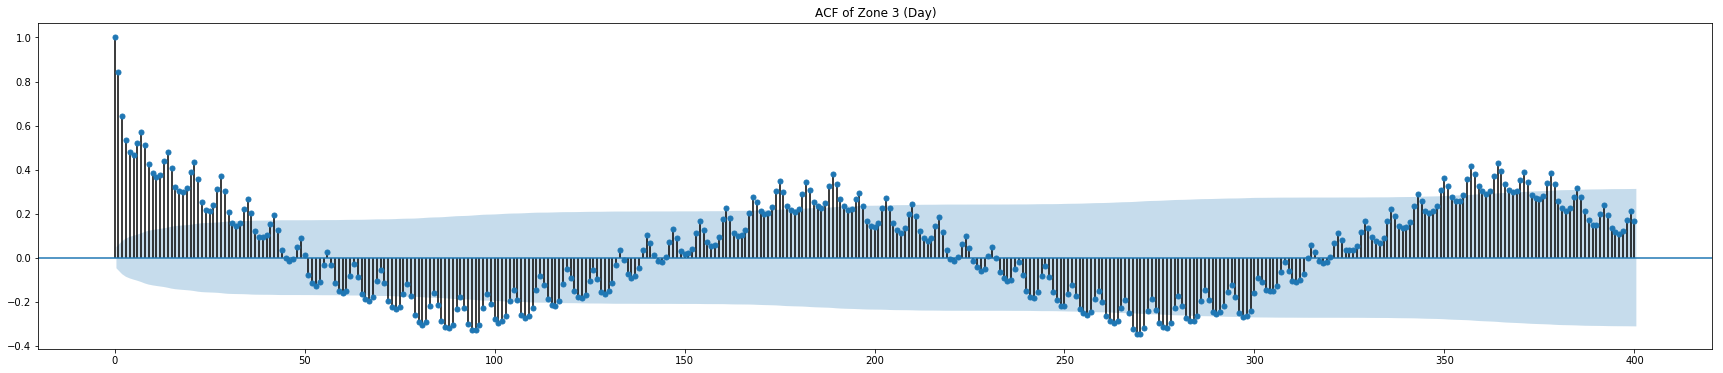

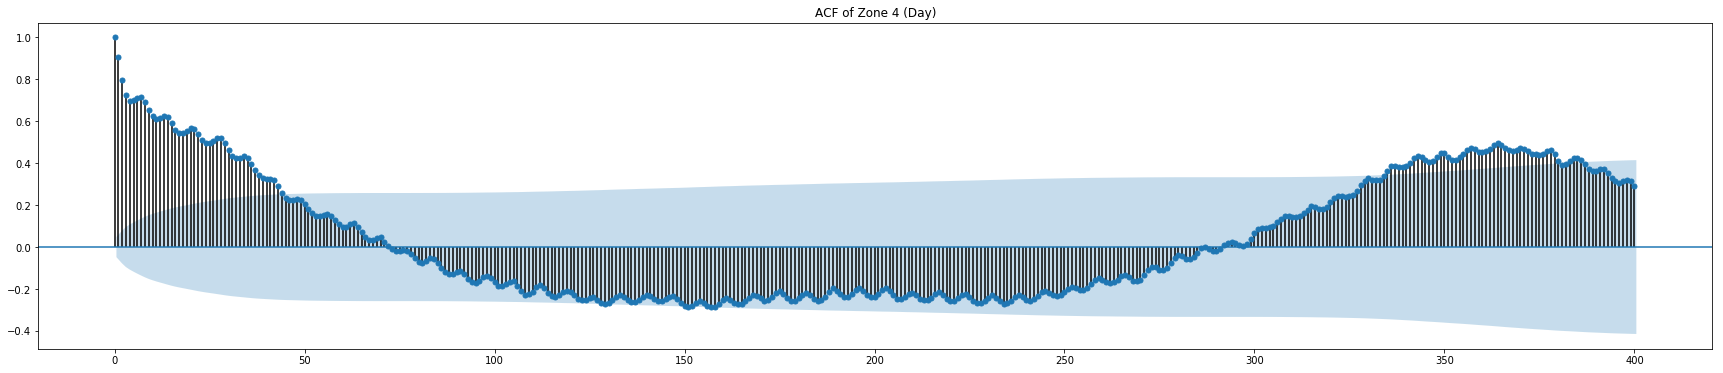

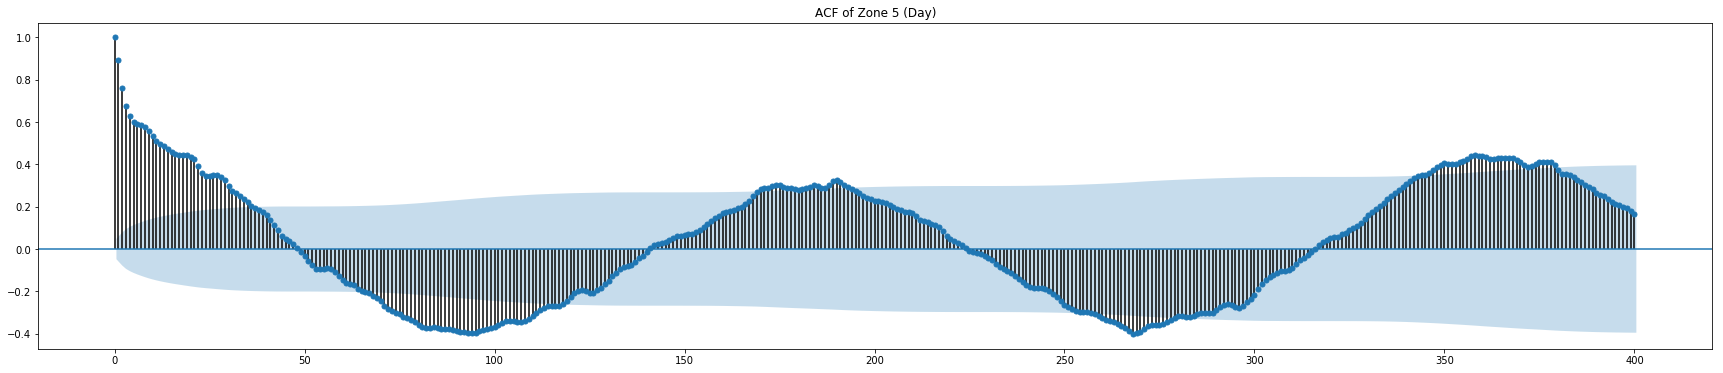

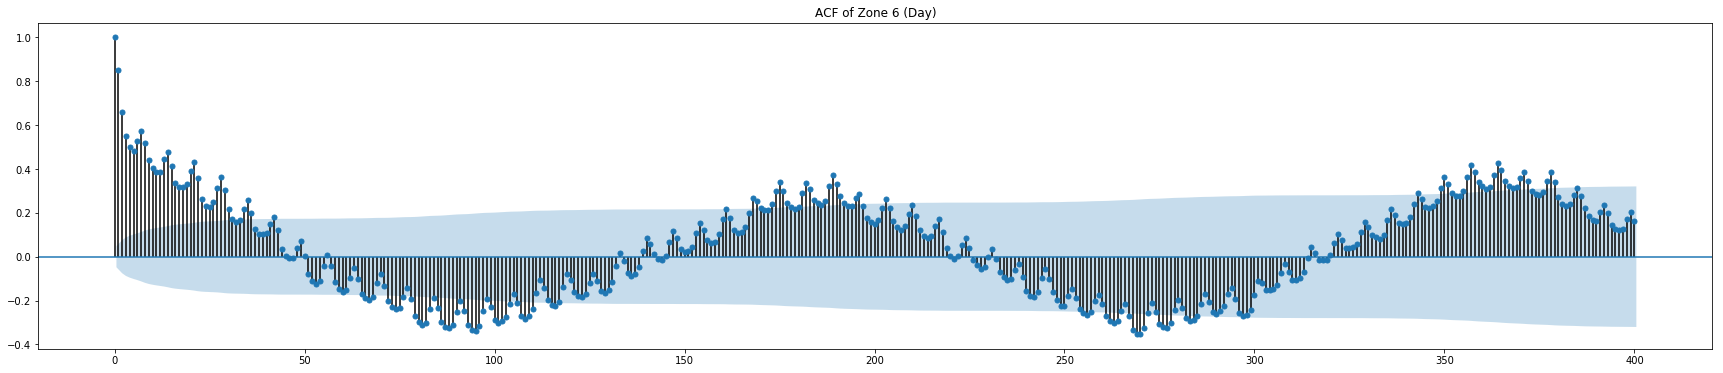

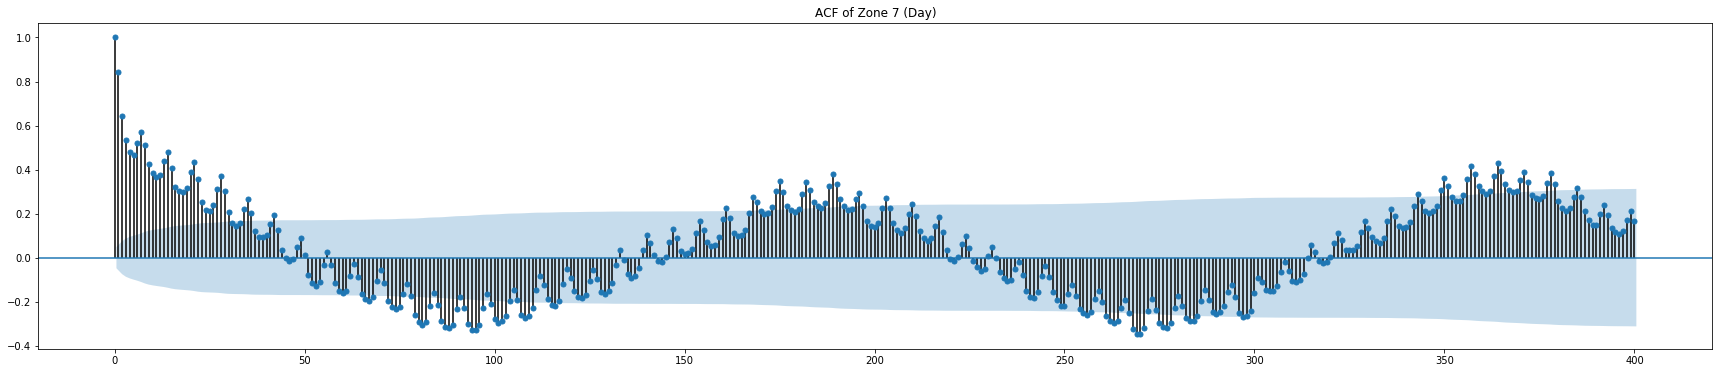

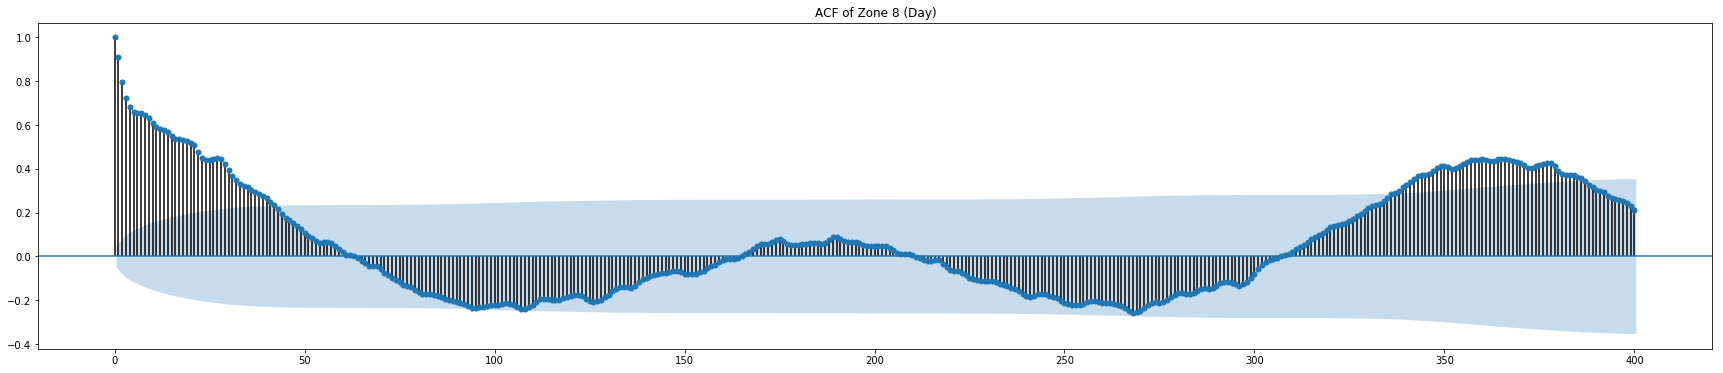

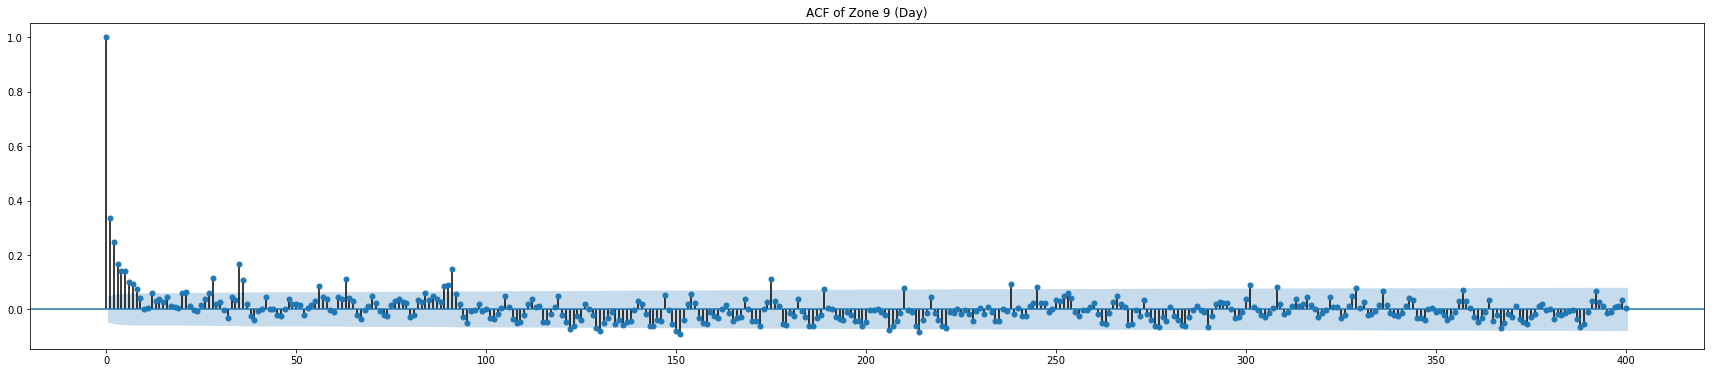

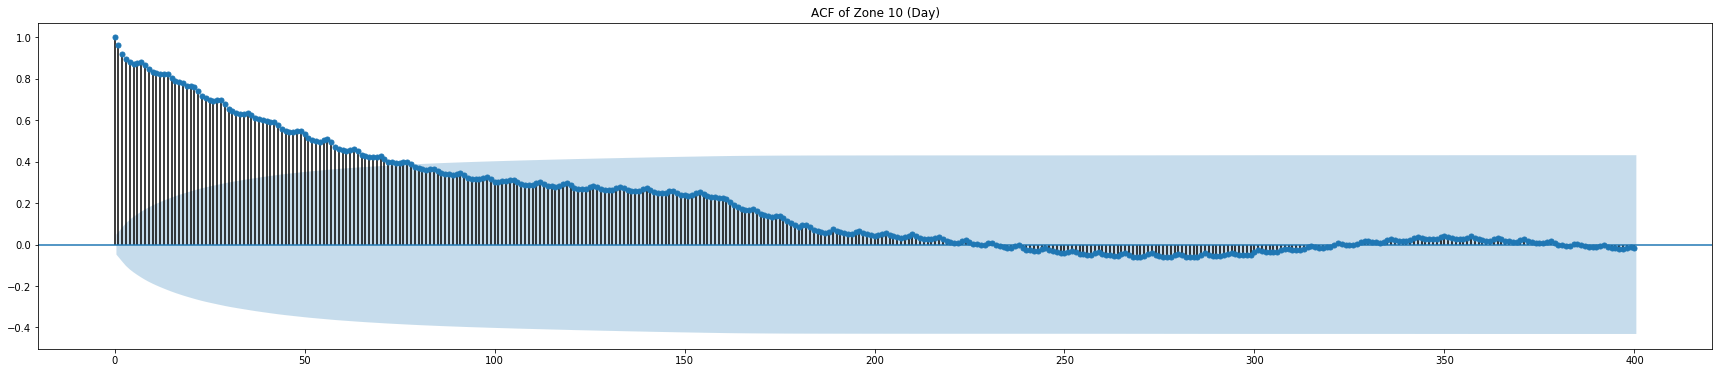

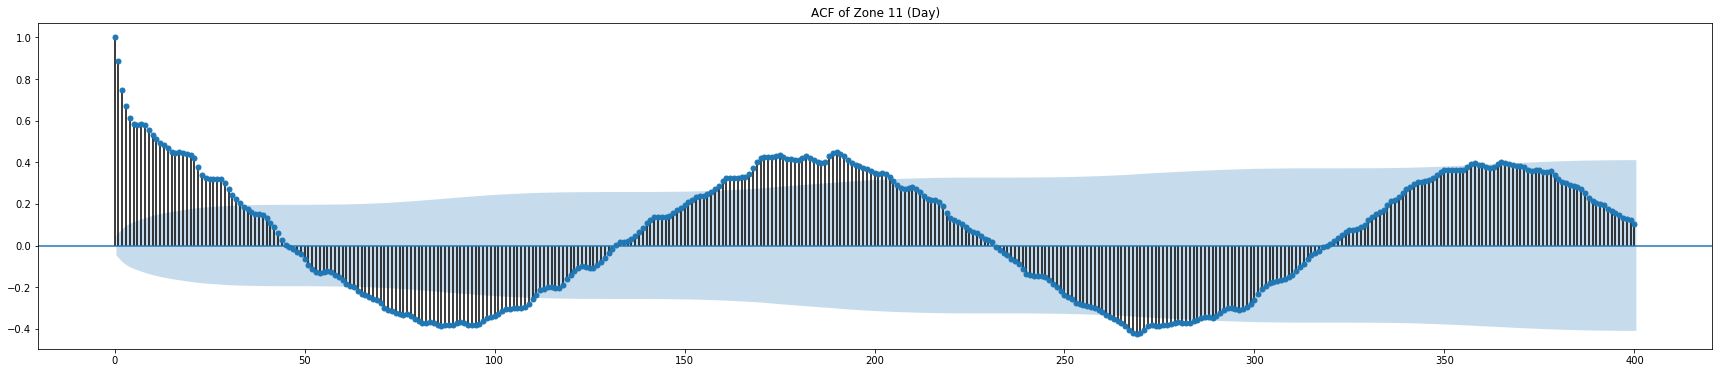

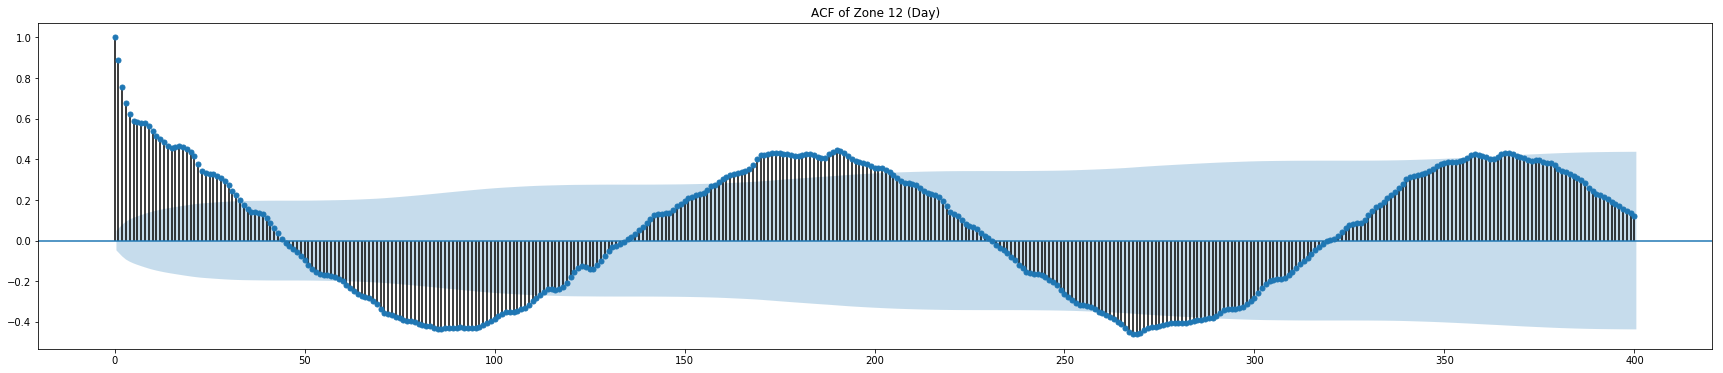

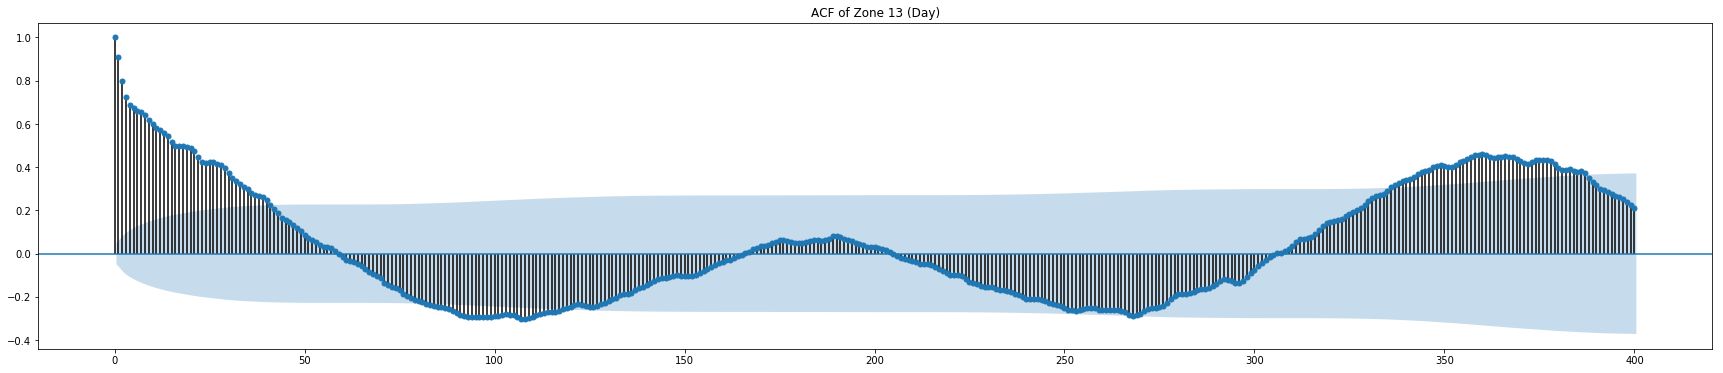

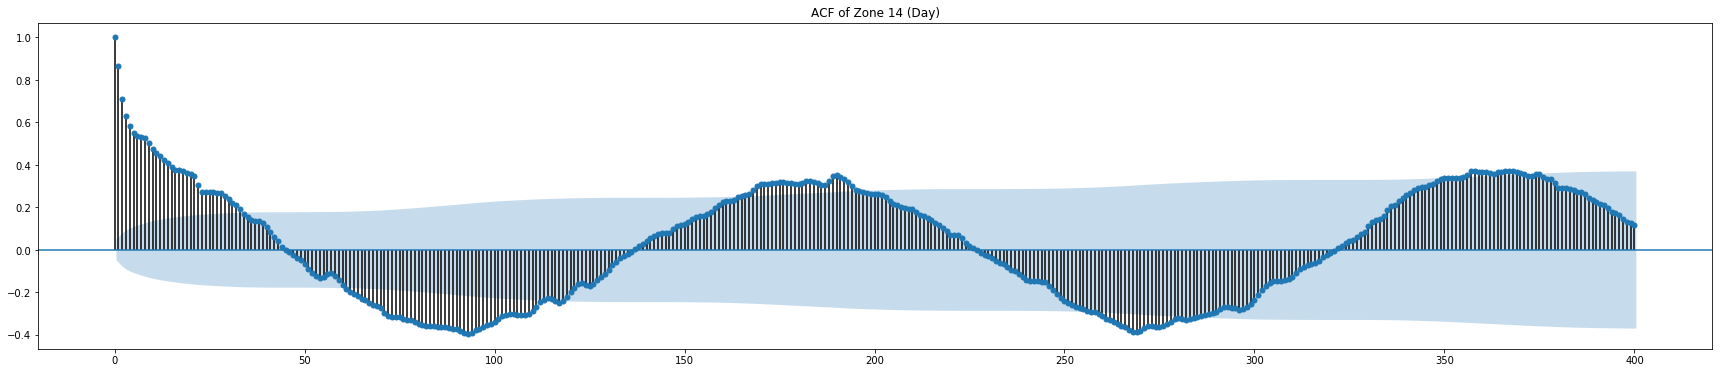

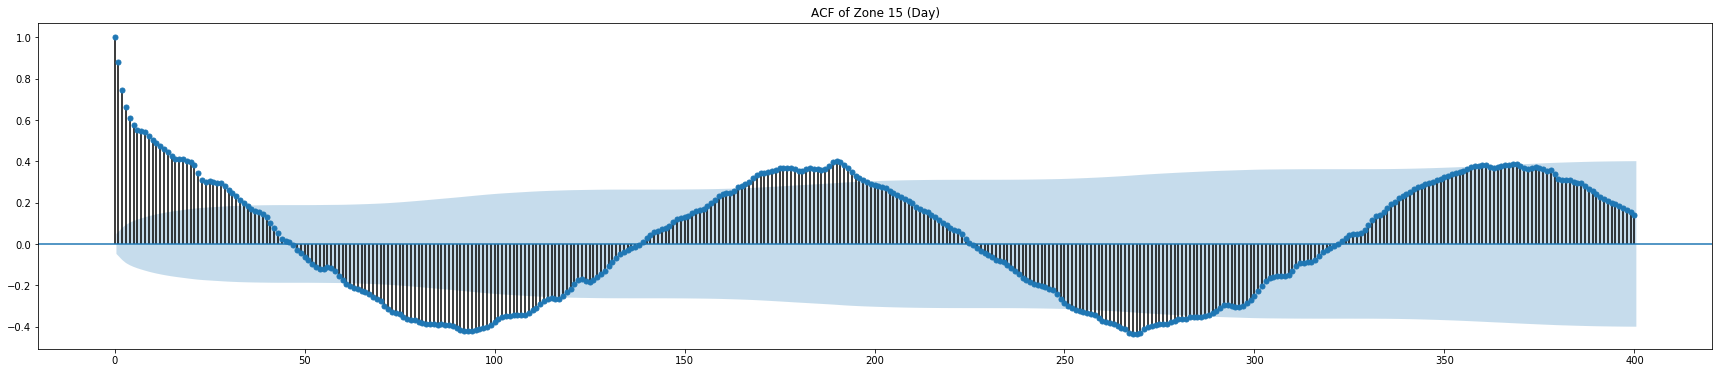

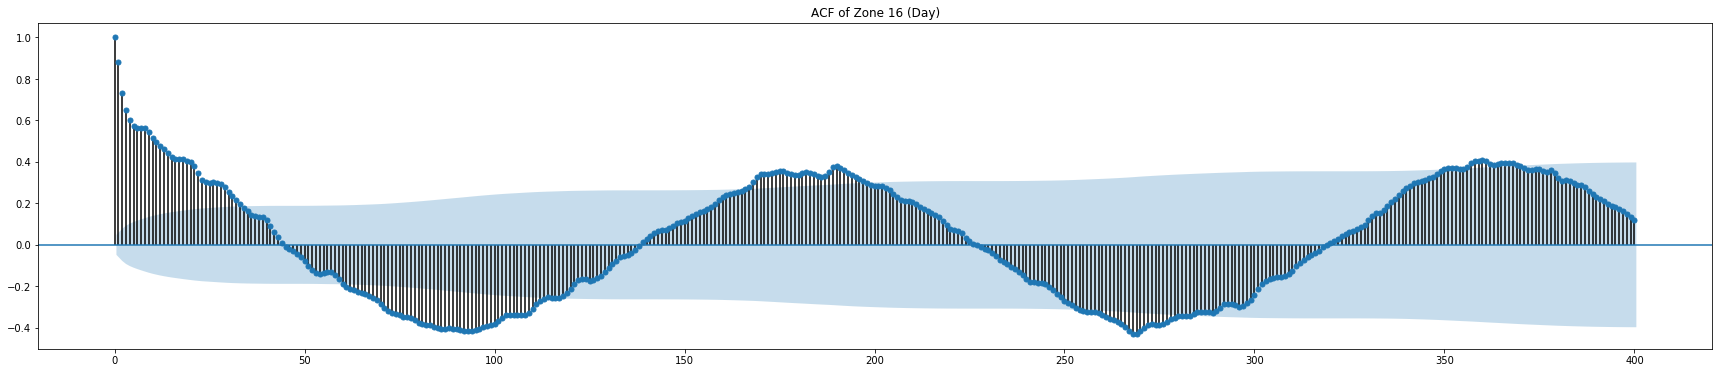

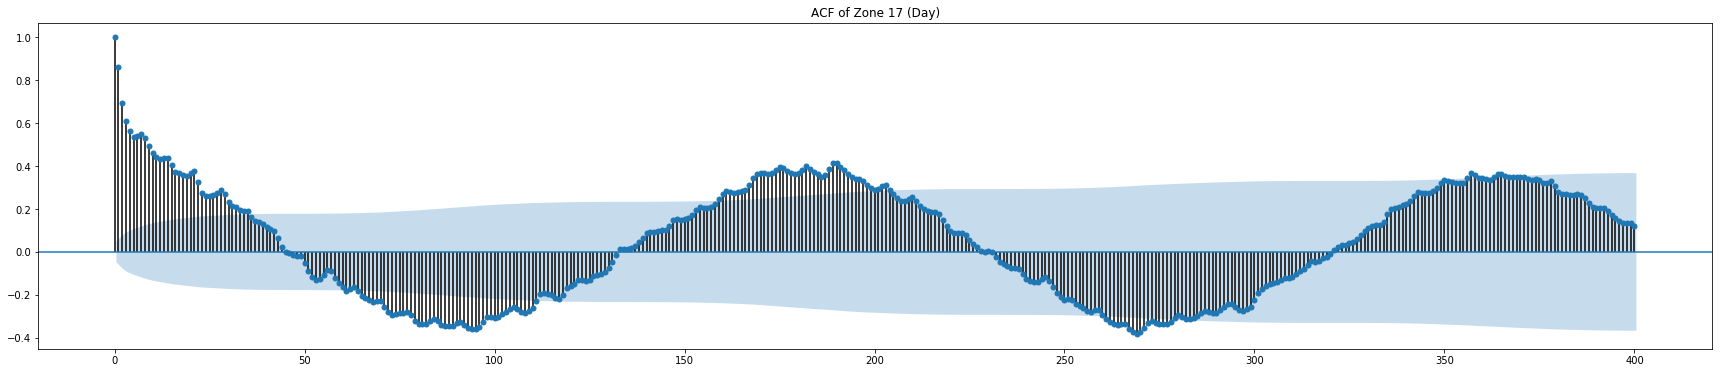

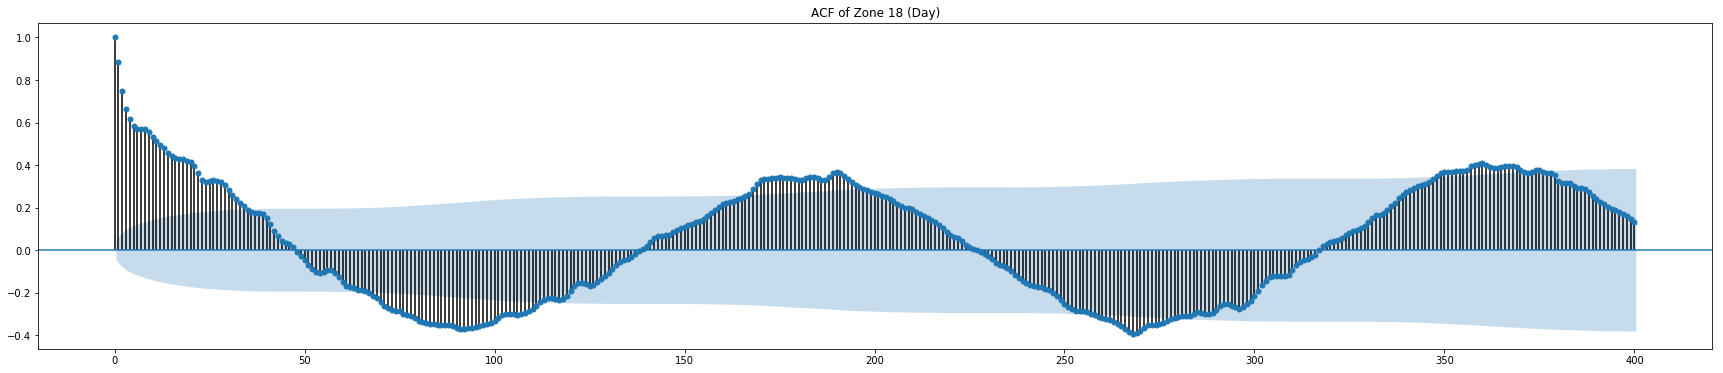

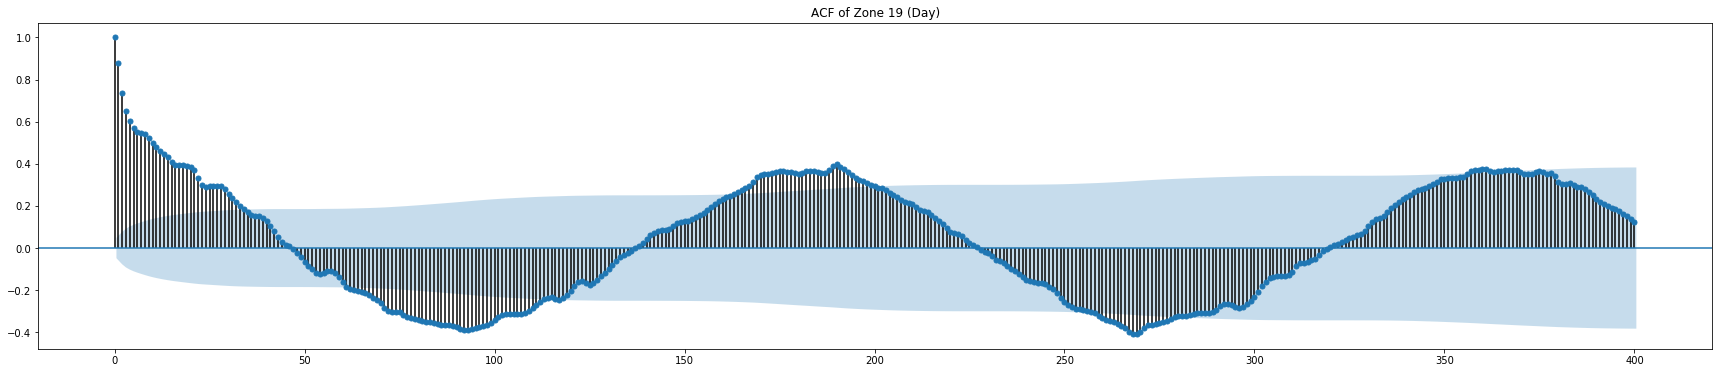

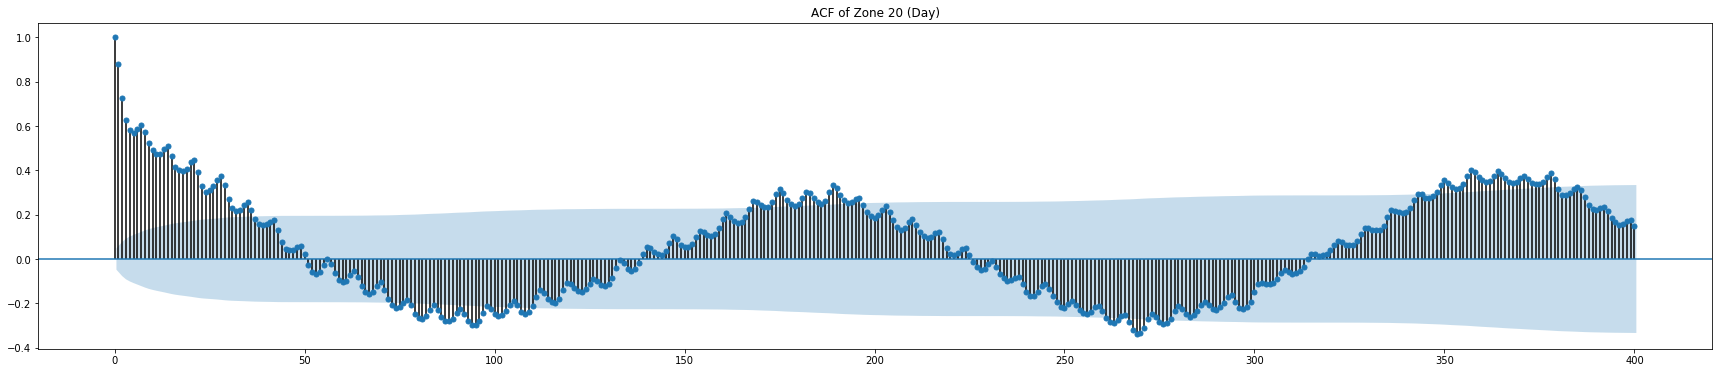

In [25]:
def getAutocorrelationPlot(df, zid, lags=400, name = 'value'):
    # from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    data = df[df['zone_id']==zid]
    plt.close()
    fig, ax = plt.subplots(figsize=(30, 6))
    df = data.resample(on='time', rule='D').mean()
    title = f'ACF of Zone {zid} (Day)'
    plot_acf(df[name].fillna(method="ffill"), lags=lags, ax=ax, title=title)
#     plt.savefig(f'result/weather/acf_name_{zid}')
    plt.show()
def getGlobalAutocorrelationPlot(df, lags=400, name='value'):
    fig, ax = plt.subplots(figsize=(30, 6))
    data = df.resample(on='time', rule='D').mean()
    title = f'ACF of Zone 21 (Day)'
    plot_acf(df[name].fillna(method="ffill"), lags=lags, ax=ax, title=title)
#     plt.savefig(f'result/weather/acf_{name}')
    plt.show()
getGlobalAutocorrelationPlot(total)
for zid in range(1, 21):
    getAutocorrelationPlot(df, zid)

### Partial Correlation Plot

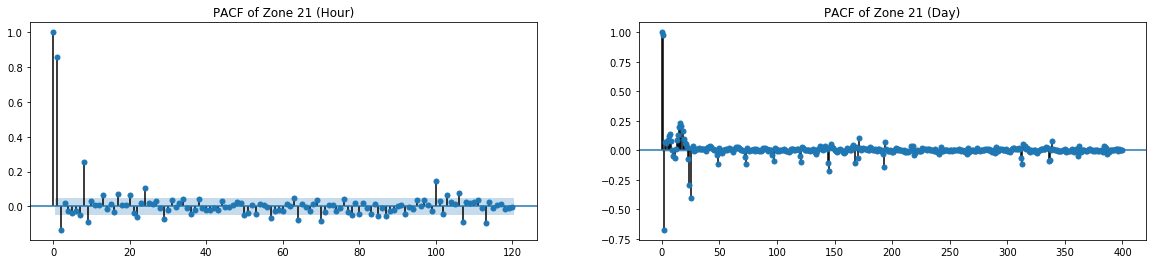

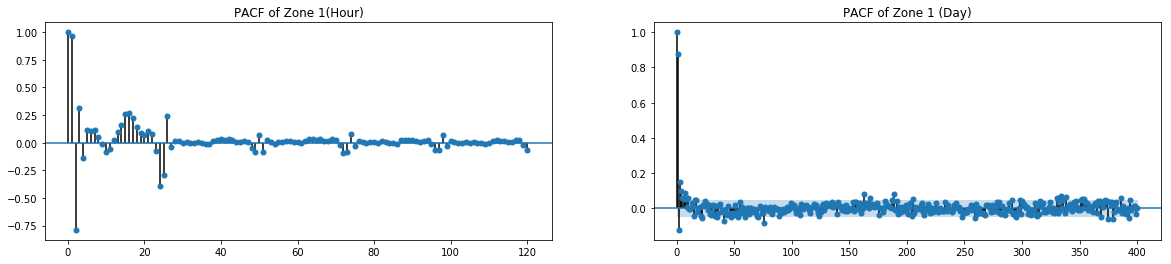

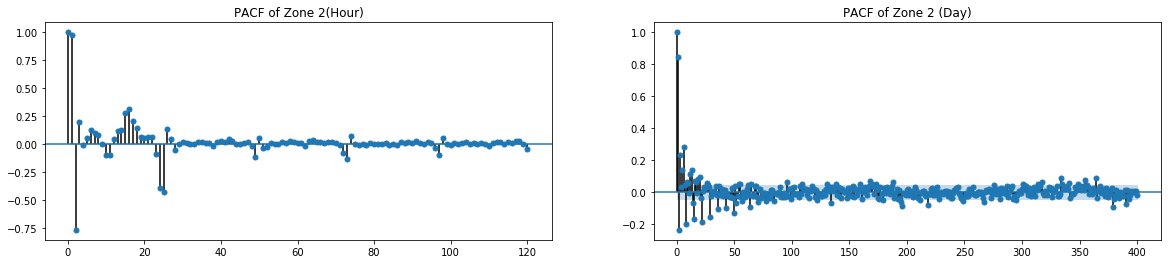

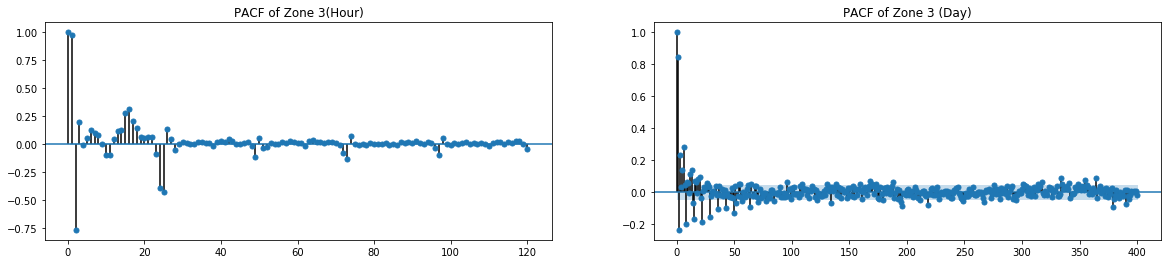

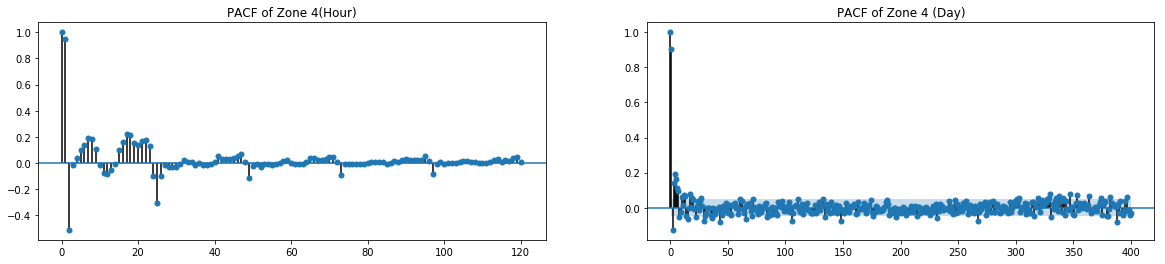

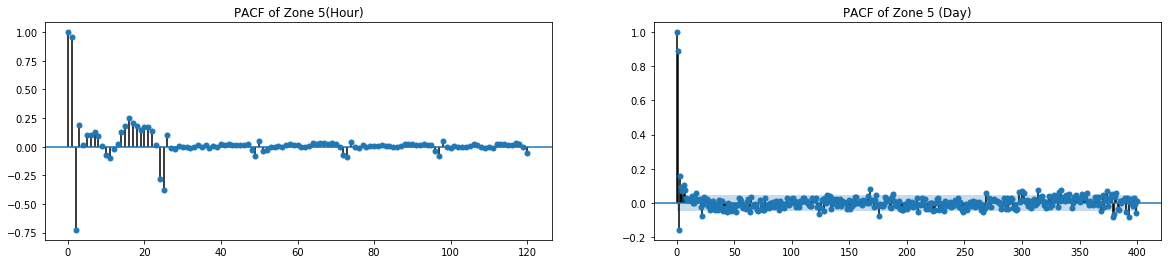

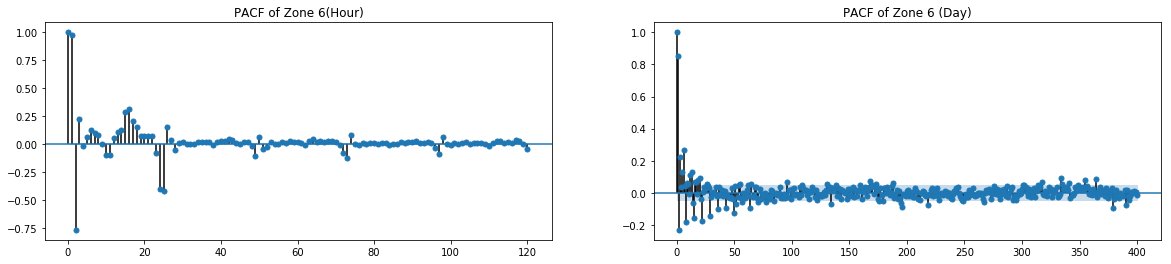

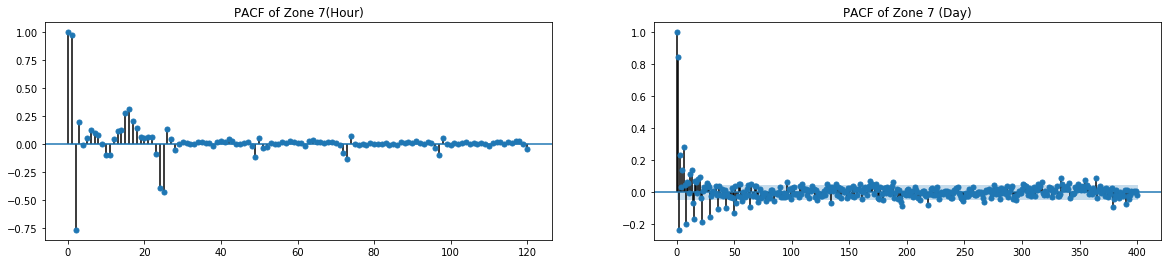

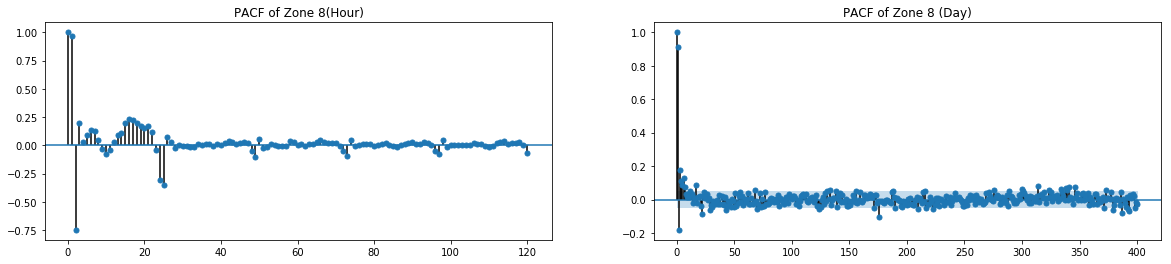

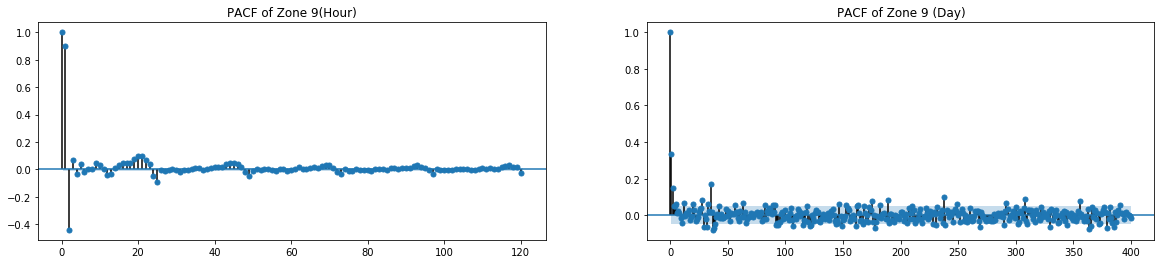

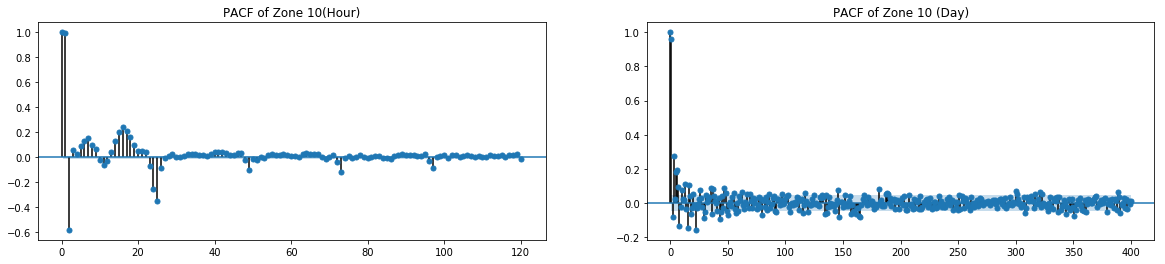

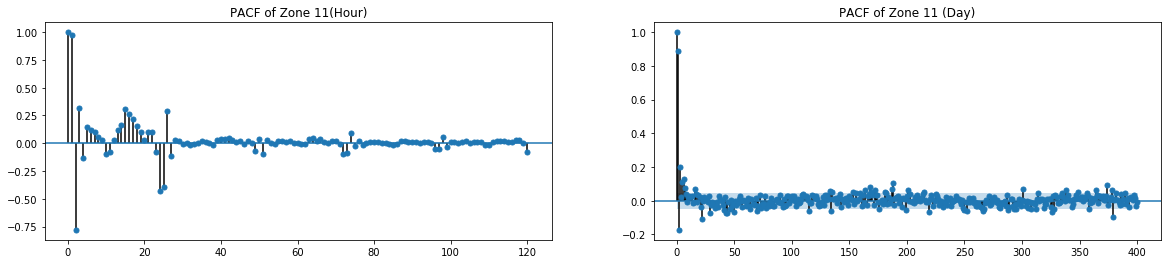

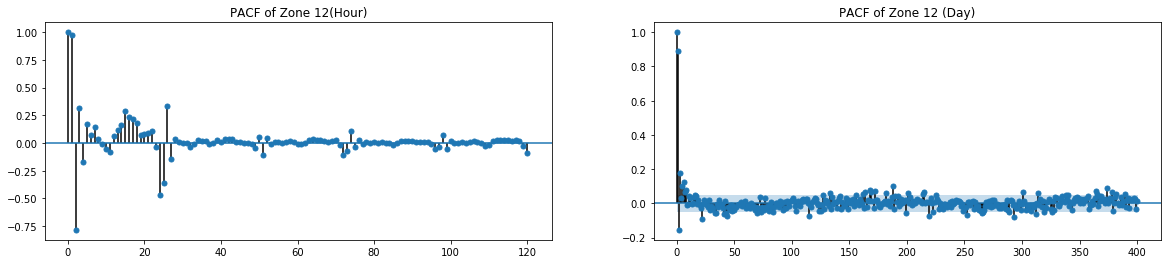

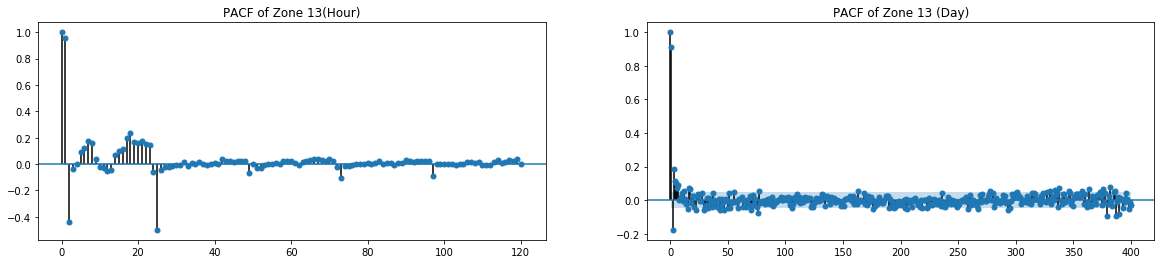

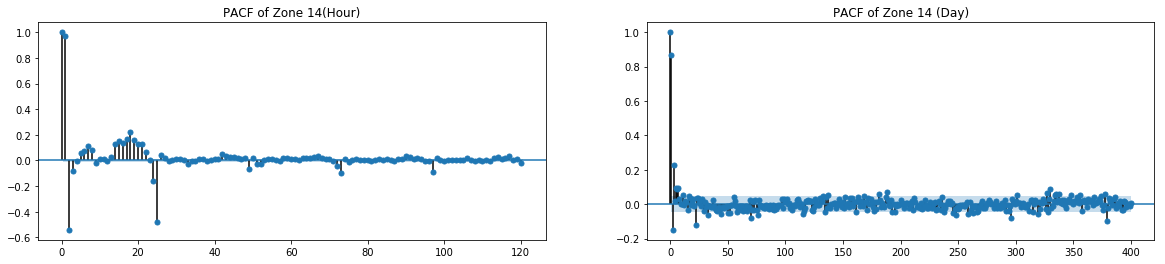

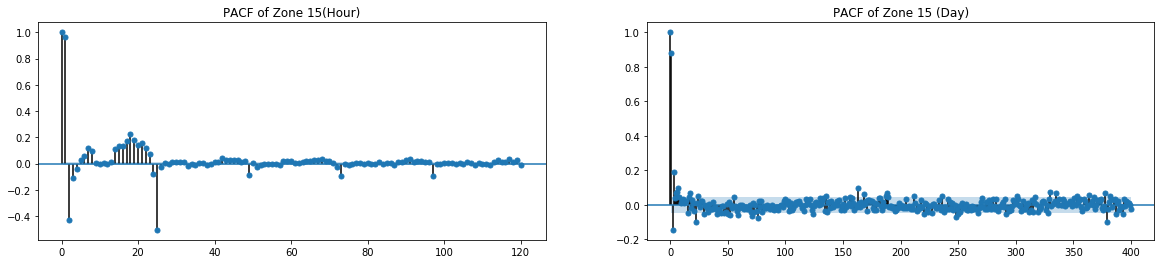

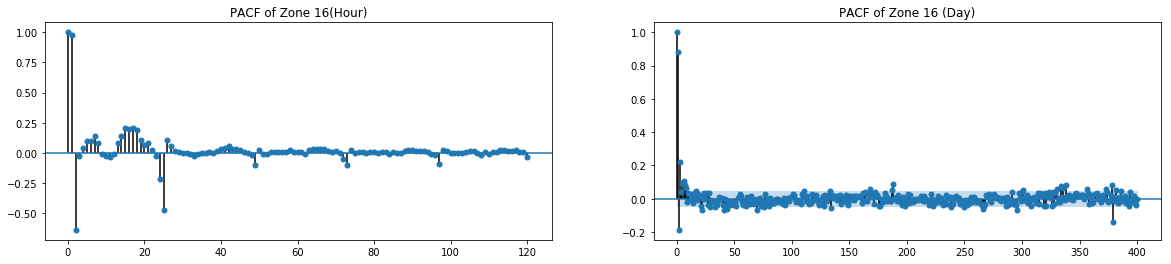

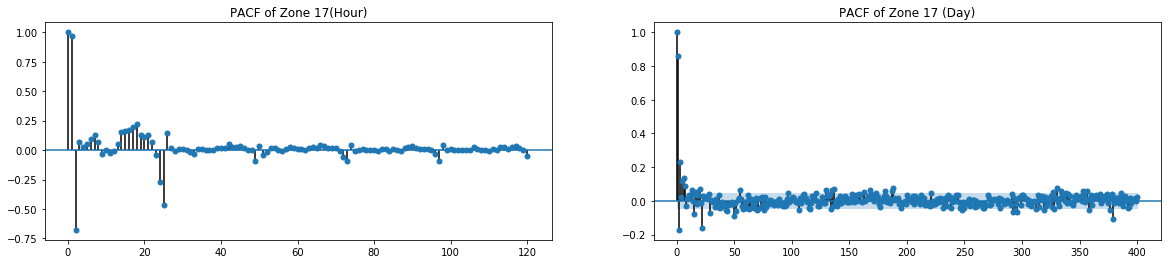

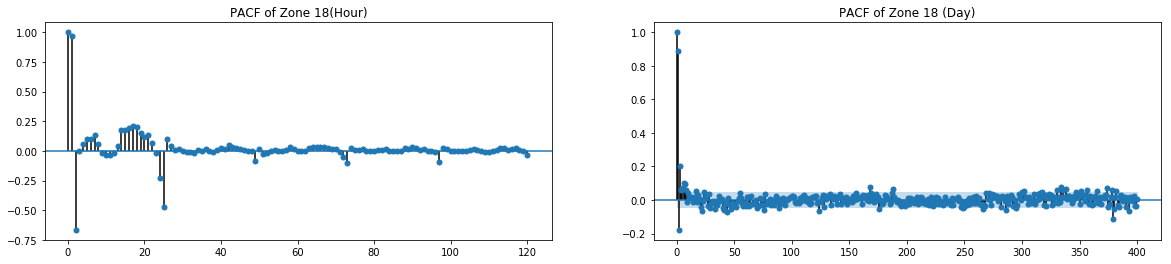

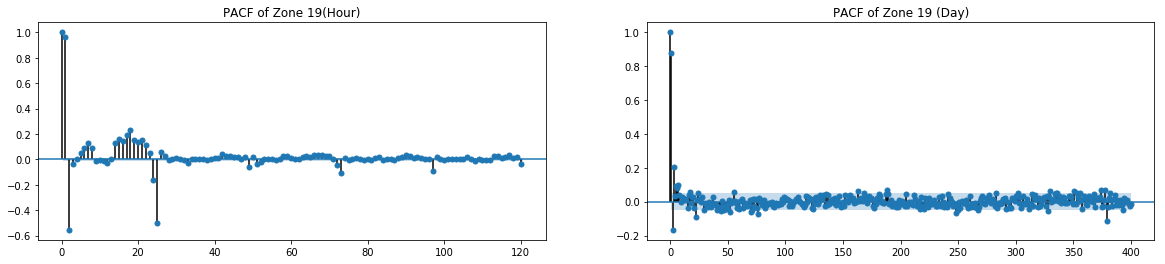

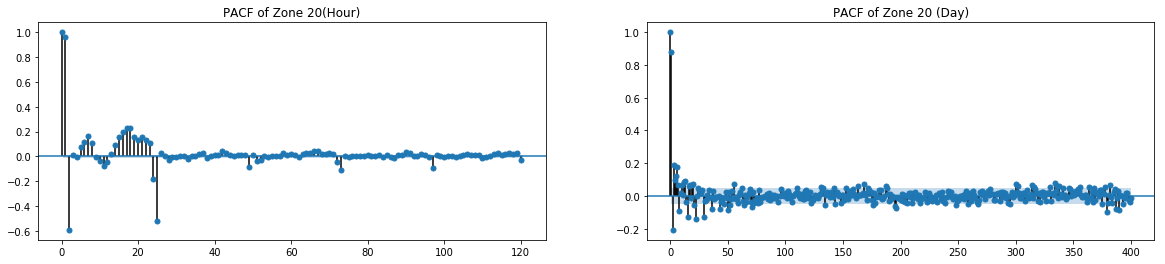

In [29]:
def getPartialAutocorrelationPlot(df, zid, name = 'value'):
    data = df[df['zone_id']==zid]
    plt.close()
    fig, ax = plt.subplots(1,2,figsize=(20, 4))
    df = data.resample(on='time', rule='D').mean()
    title = f'PACF of Zone {zid}'
    plot_pacf(df[name].fillna(method="ffill"), lags=400, ax=ax[1], title=title + ' (Day)')
    plot_pacf(data[name].fillna(method="ffill"), lags=120, ax=ax[0], title=title + '(Hour)')
#     plt.savefig(f'result/autocorrelation/pacf_name_{zid}')
    plt.show()
def getPartialGlobalAutocorrelationPlot(df, lags=400, name='value'):
    plt.close()
    fig, ax = plt.subplots(1,2, figsize=(20, 4))
    data = df.resample(on='time', rule='D').mean()
    title = f'PACF of Zone 21'
    plot_pacf(df[name].fillna(method="ffill"), lags=400, ax=ax[1], title=title + ' (Day)')
    plot_pacf(data[name].fillna(method="ffill"), lags=120, ax=ax[0], title=title + ' (Hour)')
#     plt.savefig(f'result/autocorrelation/pacf_21')
    plt.show()
getPartialGlobalAutocorrelationPlot(total)
for zid in range(1, 21):
    getPartialAutocorrelationPlot(df, zid)

### Seasonality

- Hourly, Monthly
- Still, Zone 9 and Zone 10 is really abnormal.
- Different zones range differently.

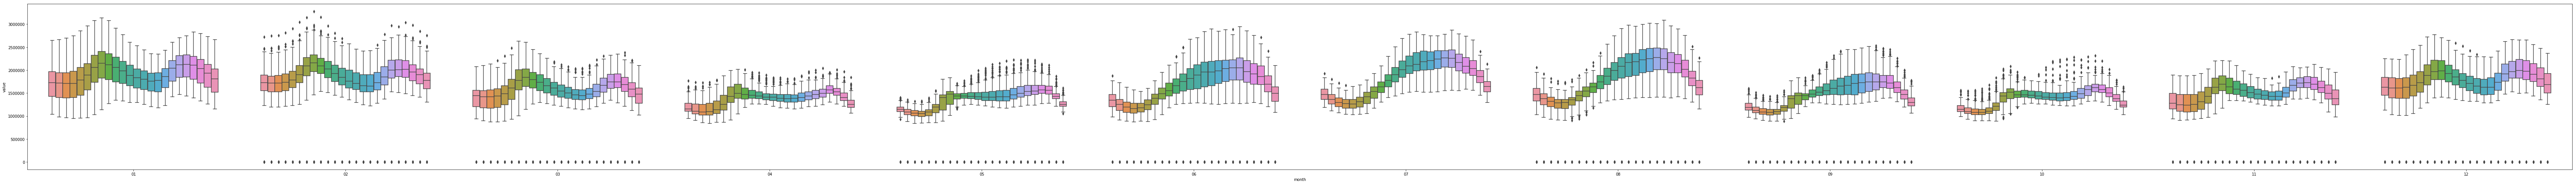

In [36]:
def getstr(x):
    return x.get_string()
total['day'] = total['time'].apply(lambda x:x.strftime("%HH"))
total['month'] = total['time'].apply(lambda x: x.strftime('%m'))
total['year'] = total['time'].apply(lambda x:x.strftime('%y'))
plt.close()
fig, ax = plt.subplots(figsize=(120, 8))
g = sns.boxplot(x='month', y='value', data=total, ax=ax, hue='day')
ax.get_legend().remove()
plt.show()

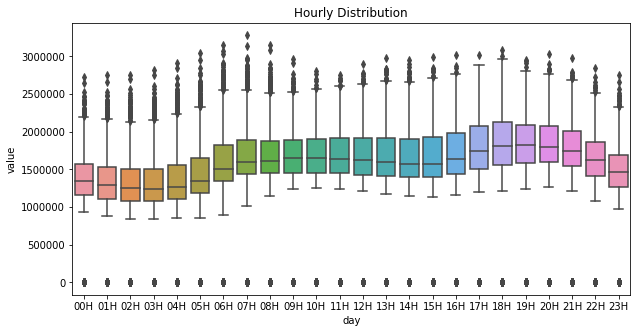

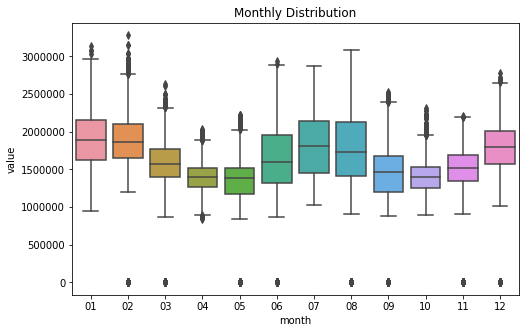

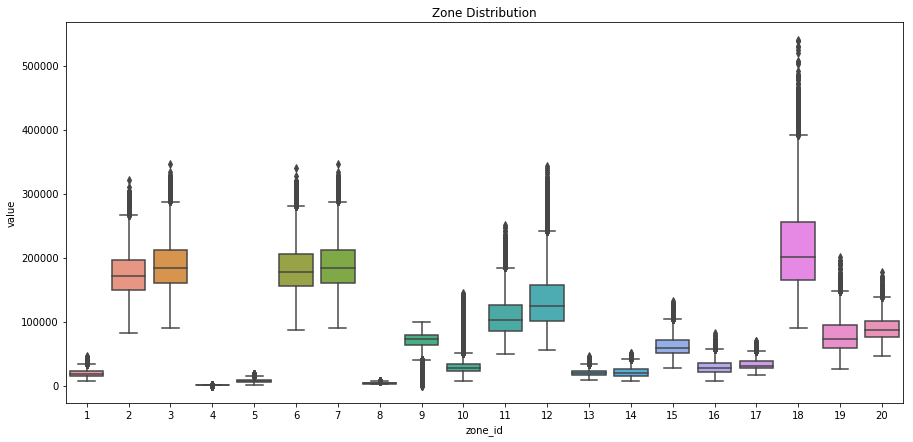

In [52]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.boxplot(x='day', y='value', data=total, ax=ax)
plt.title('Hourly Distribution')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.boxplot(x='month', y='value', data=total, ax=ax)
plt.title('Monthly Distribution')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(15, 7))
g = sns.boxplot(x='zone_id', y='value', data=df, ax=ax)
plt.title('Zone Distribution')
plt.show()

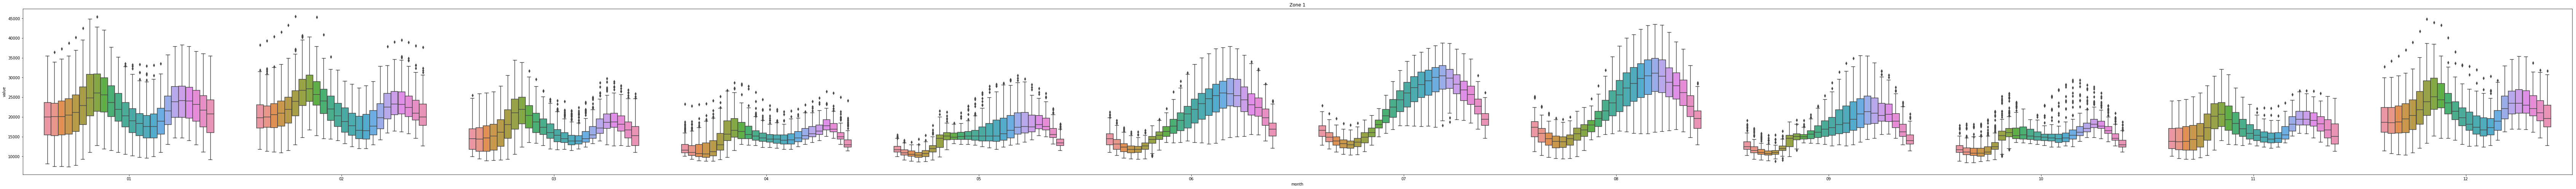

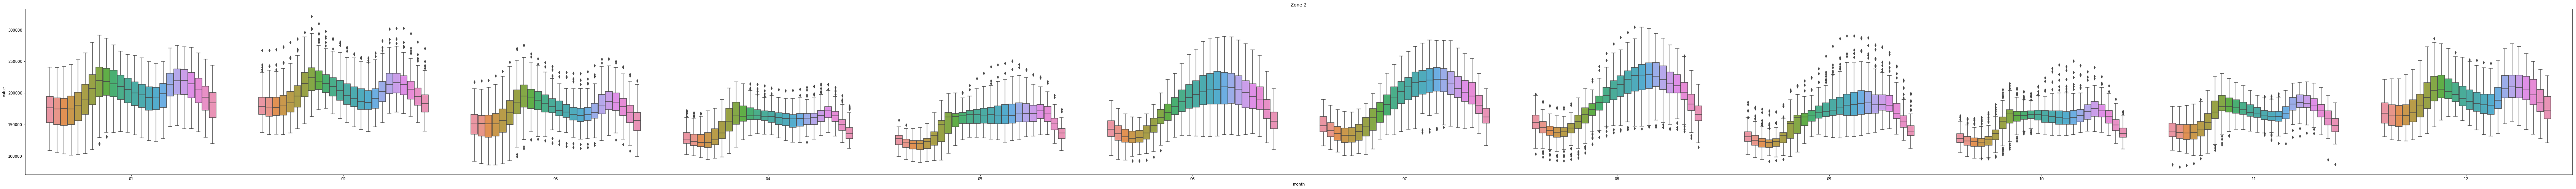

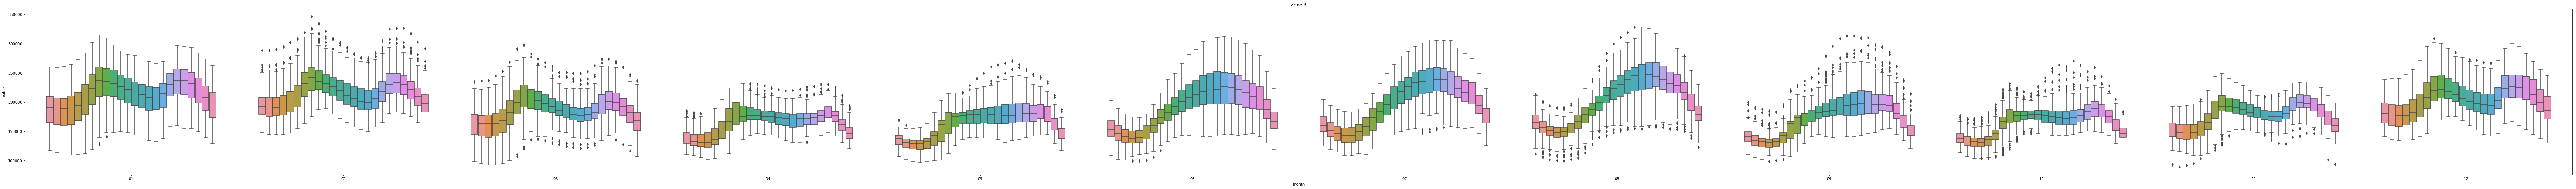

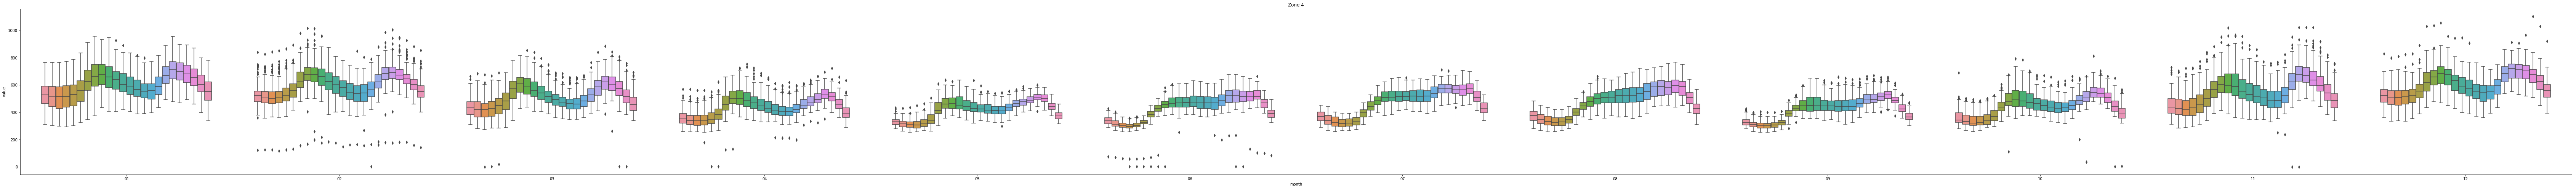

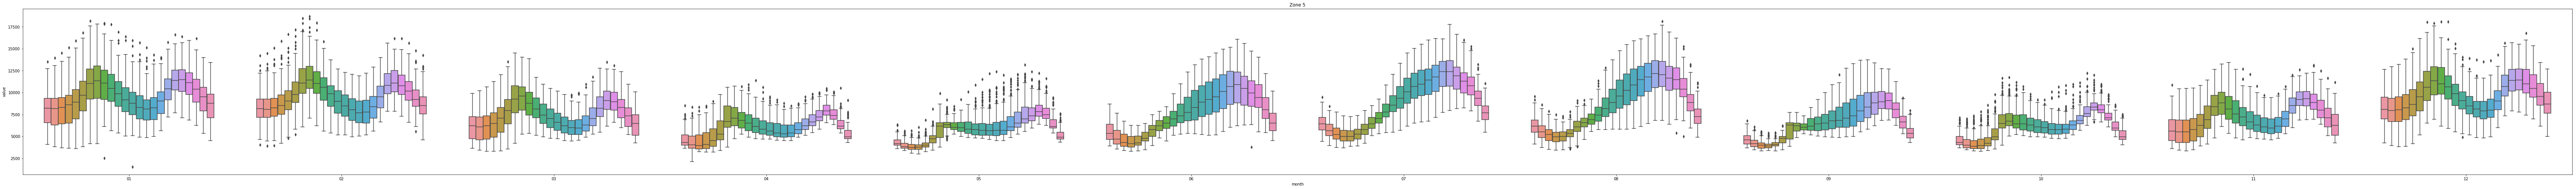

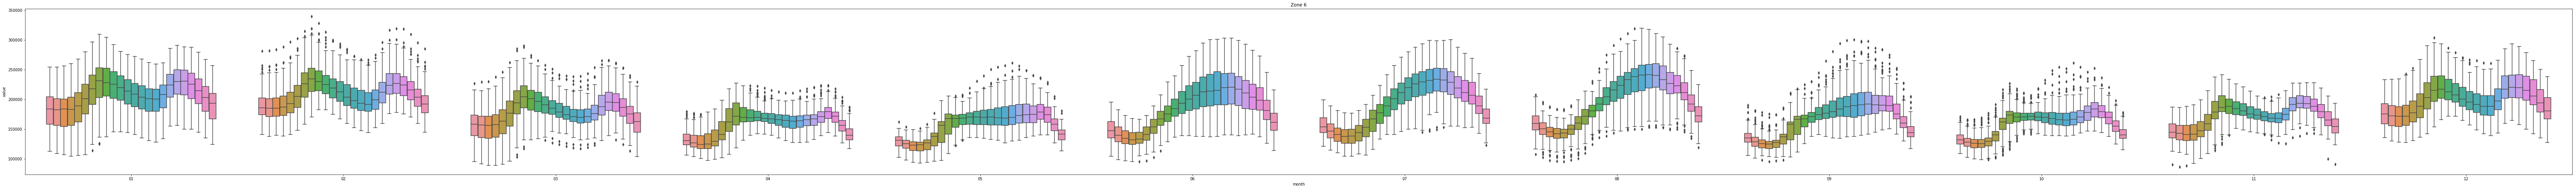

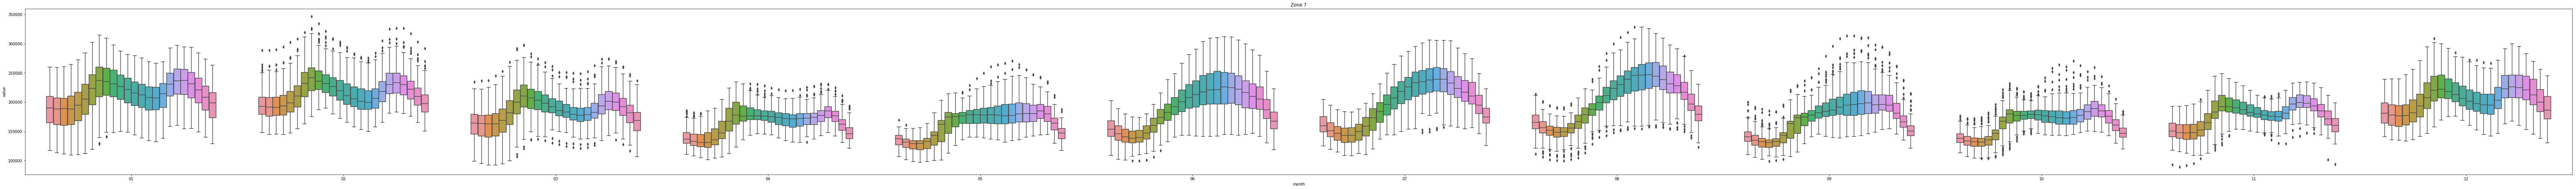

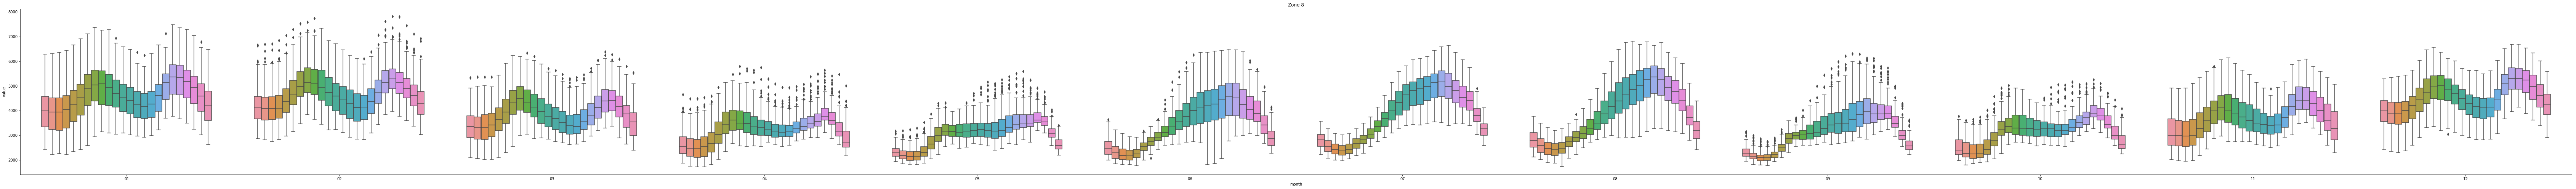

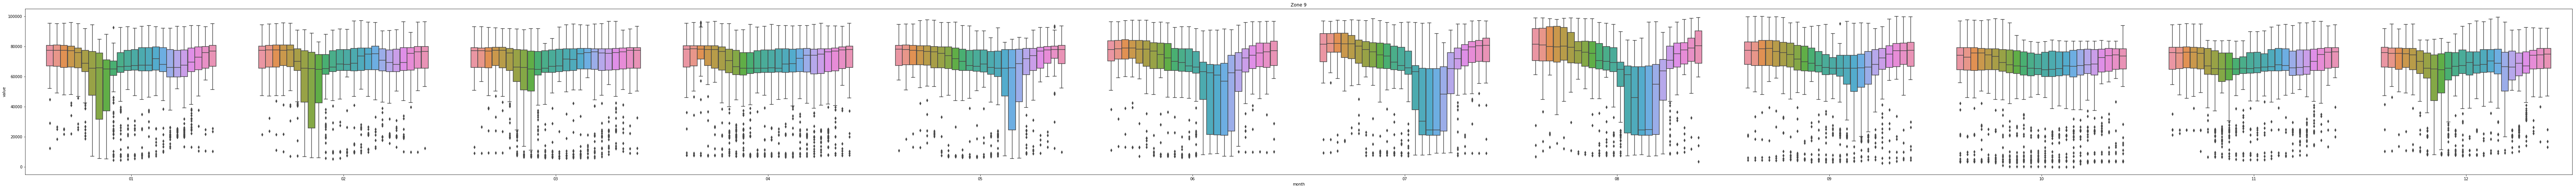

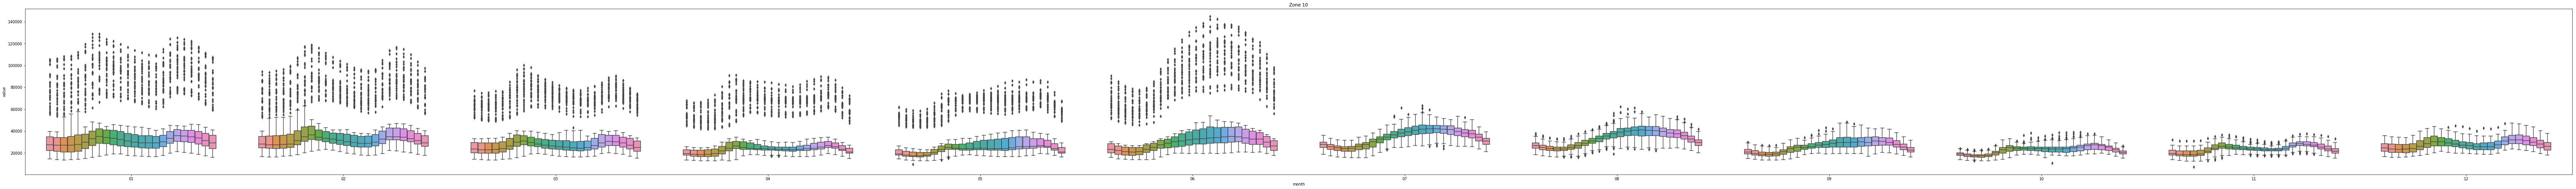

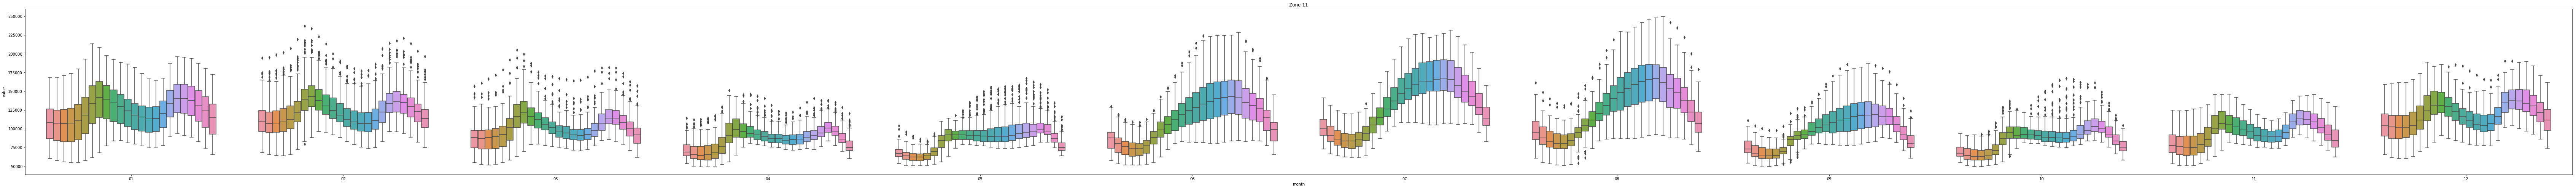

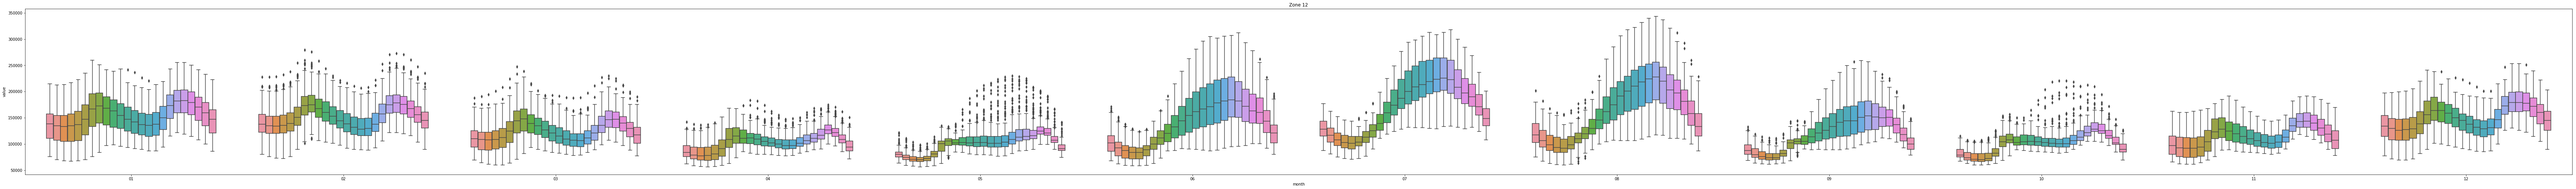

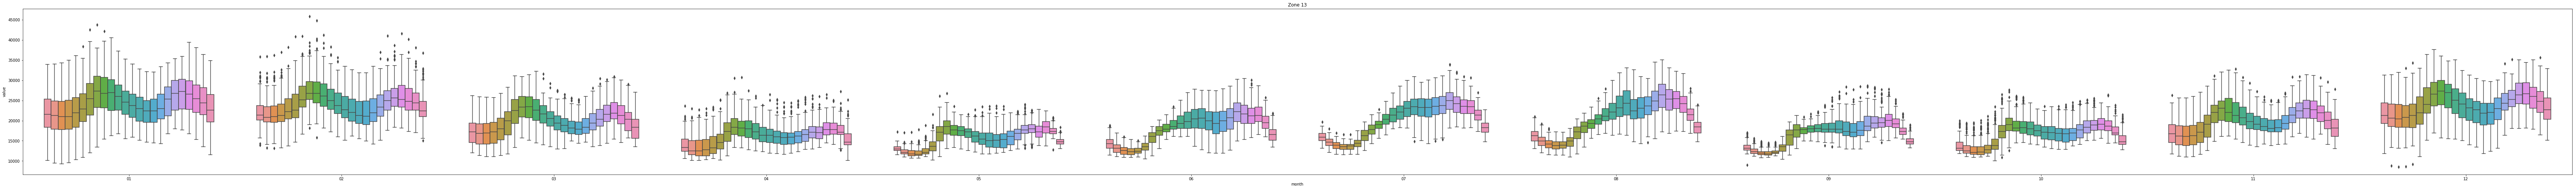

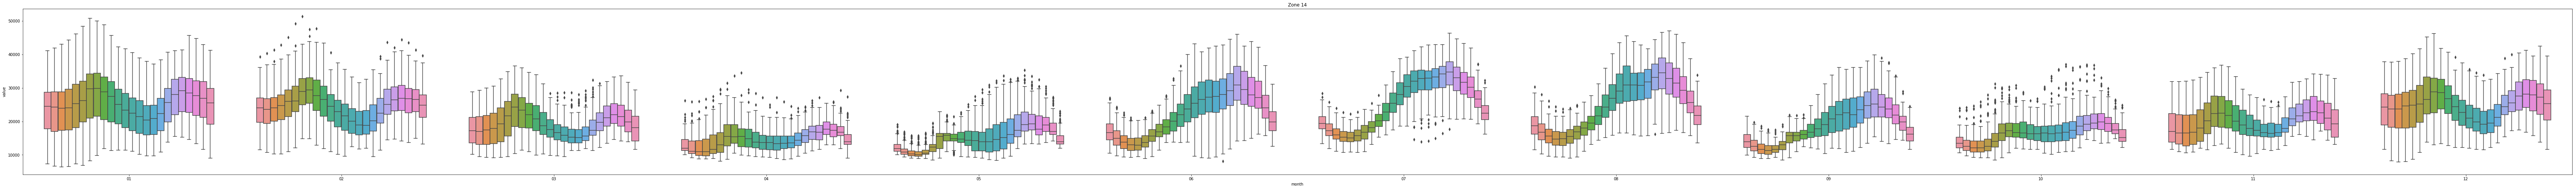

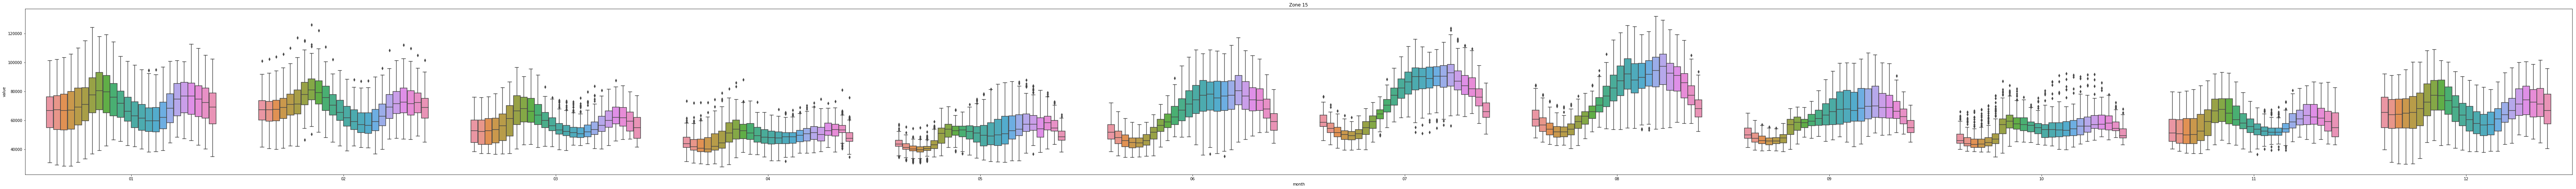

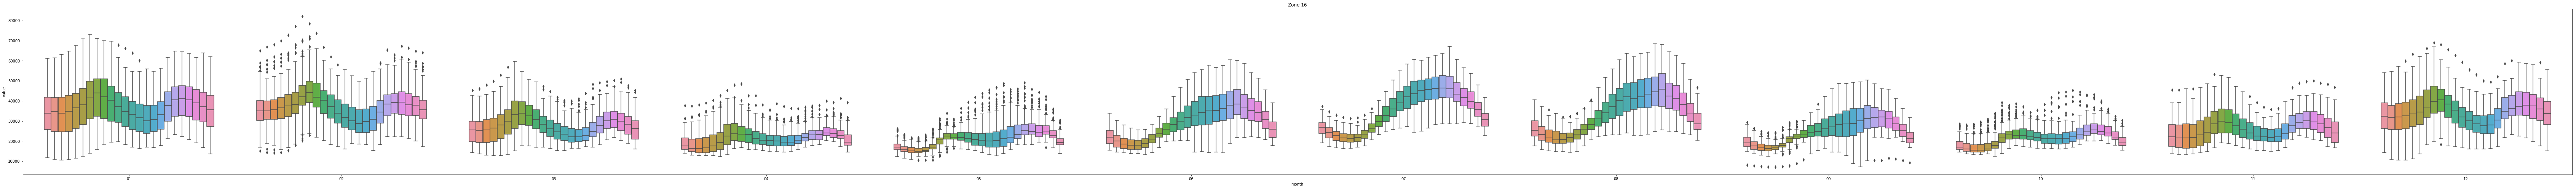

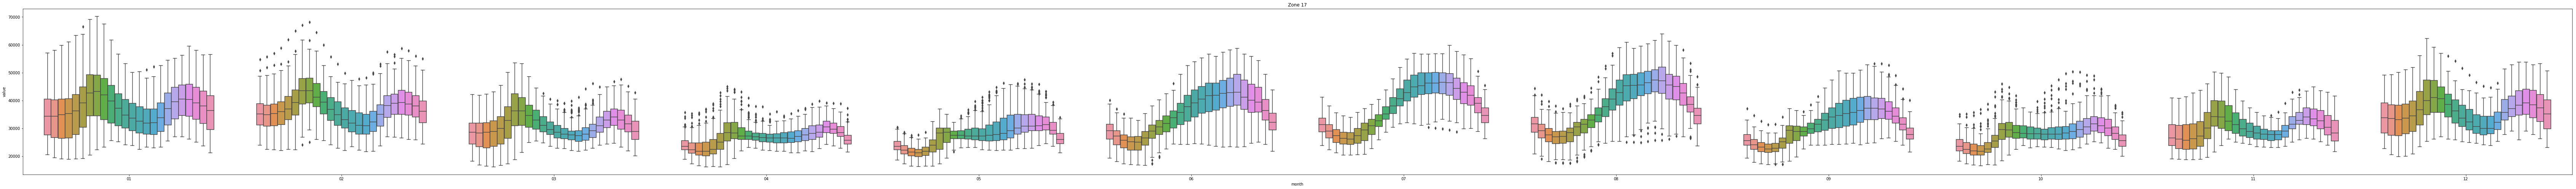

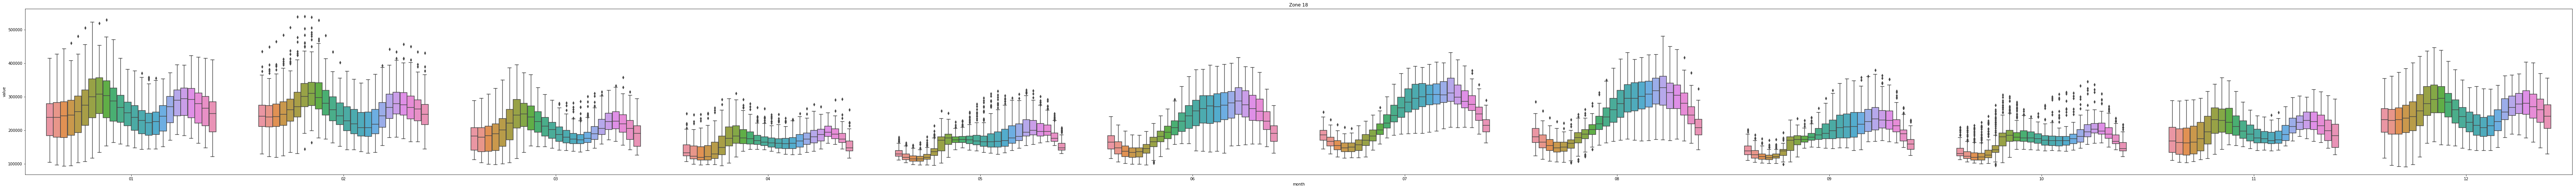

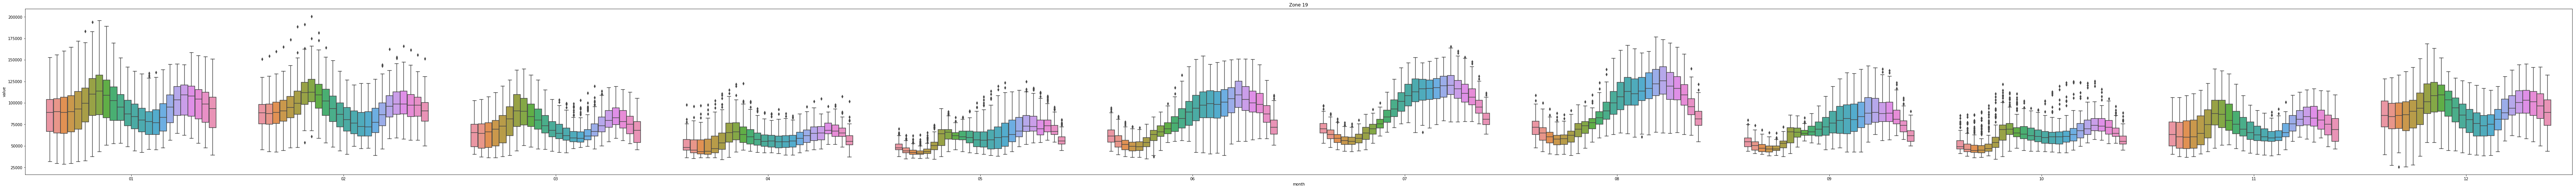

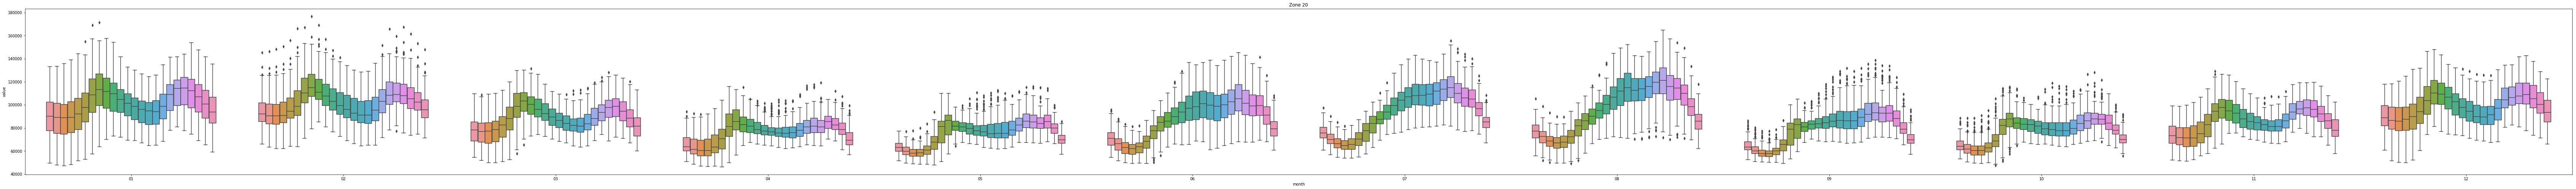

In [54]:
df['day'] = df['time'].apply(lambda x:x.strftime("%HH"))
df['month'] = df['time'].apply(lambda x: x.strftime('%m'))
df['year'] = df['time'].apply(lambda x:x.strftime('%y'))

for zid in range(1, 21):
    plt.close()
    fig, ax = plt.subplots(figsize=(120, 8))
    g = sns.boxplot(x='month', y='value', data=df[df['zone_id']==zid], ax=ax, hue='day')
    ax.get_legend().remove()
    plt.title(f'Zone {zid}')
    plt.show()